**Projet : Prédiction de la demande potentielle en retail alimentaire**

**Installation des bibliothèques nécessaires**

In [31]:
%pip install datasets pyarrow pandas numpy lightgbm shap

In [32]:
# Bibliothèques de base
import pandas as pd
import numpy as np
from datasets import load_dataset

# Prétraitement et pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Séparation train/test
from sklearn.model_selection import train_test_split

# Modèle MLP
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# Évaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

**Chargement du dataset FreshRetailNet-50K depuis Hugging Face**

In [26]:
ds = load_dataset("Dingdong-Inc/FreshRetailNet-50K")

**Nettoyage des données : filtrage des villes**

In [33]:
# Convert to pandas DataFrames
train_df = ds['train'].to_pandas()
eval_df = ds['eval'].to_pandas()

city_ids_to_remove = [0,16,12,3]
# Nombre de lignes avant suppression
print("Nombre total avant :", len(train_df))

# Suppression
train_df = train_df[~train_df['city_id'].isin(city_ids_to_remove)].copy()
eval_df = eval_df[~eval_df['city_id'].isin(city_ids_to_remove)].copy()

# Nombre de lignes après suppression
print("Nombre total après :", len(train_df))

Nombre total avant : 4500000
Nombre total après : 1070640


**Exploration et compréhension des données**


Training set shape: (1070640, 19)
Evaluation set shape: (83272, 19)

train_df:
  Rows: 1,070,640 | Cities: 14 | Stores: 311 | Products: 544
  Period: 2024-03-28 00:00:00 -> 2024-06-25 00:00:00
  Stockout rate: 45.165%

eval_df:
  Rows: 83,272 | Cities: 14 | Stores: 311 | Products: 544
  Period: 2024-06-26 00:00:00 -> 2024-07-02 00:00:00
  Stockout rate: 40.358%

1. ANALYSE GEOGRAPHIQUE


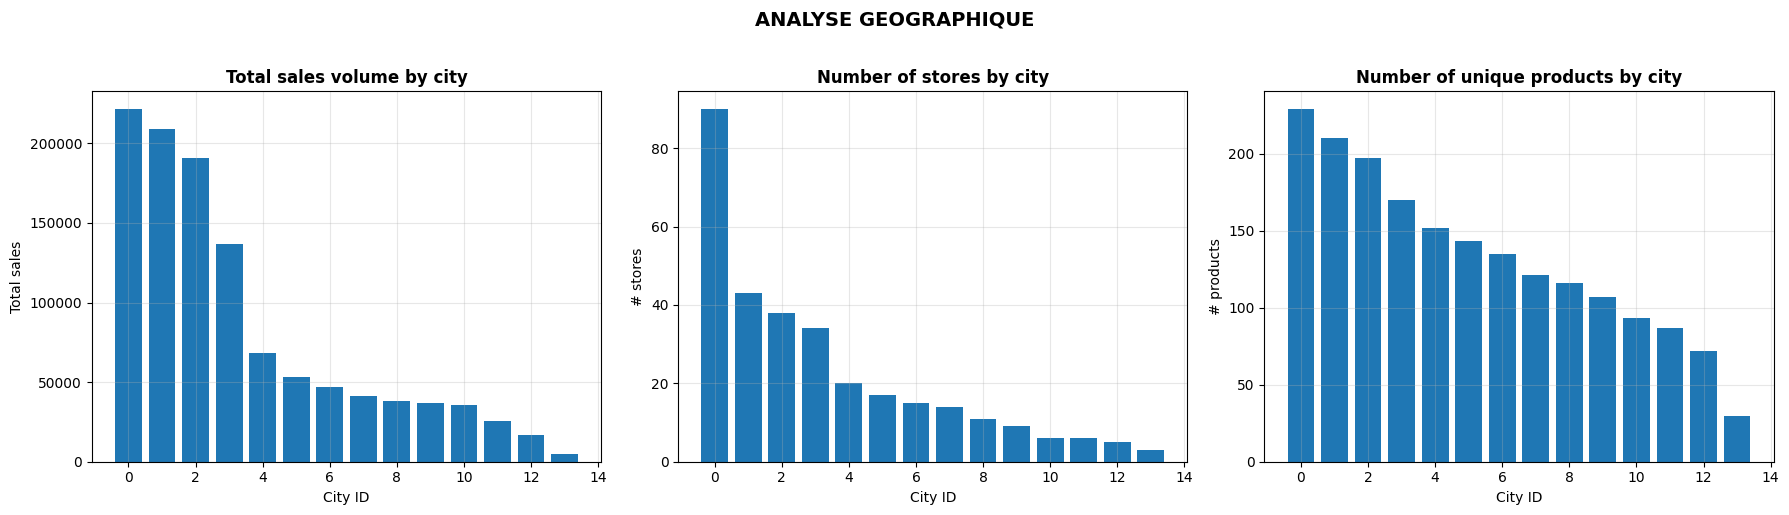


2. ANALYSE TEMPORELLE


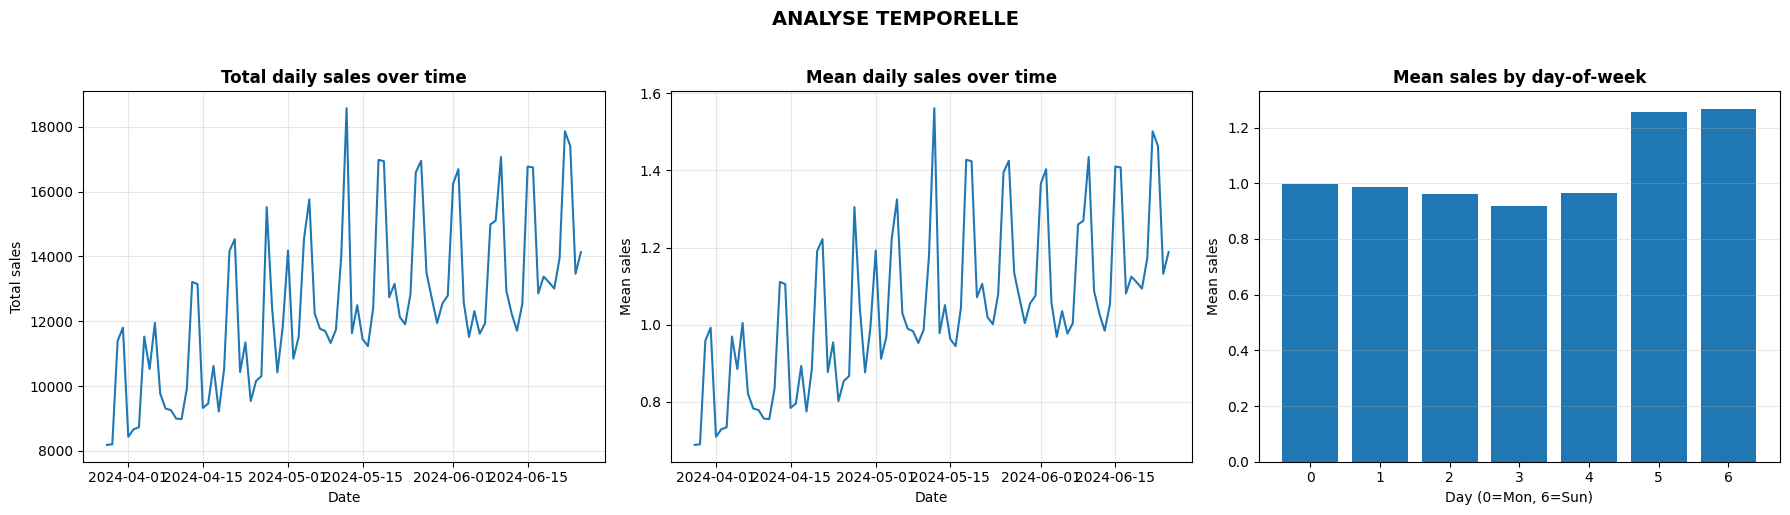


3. RUPTURES ET DISPONIBILITE


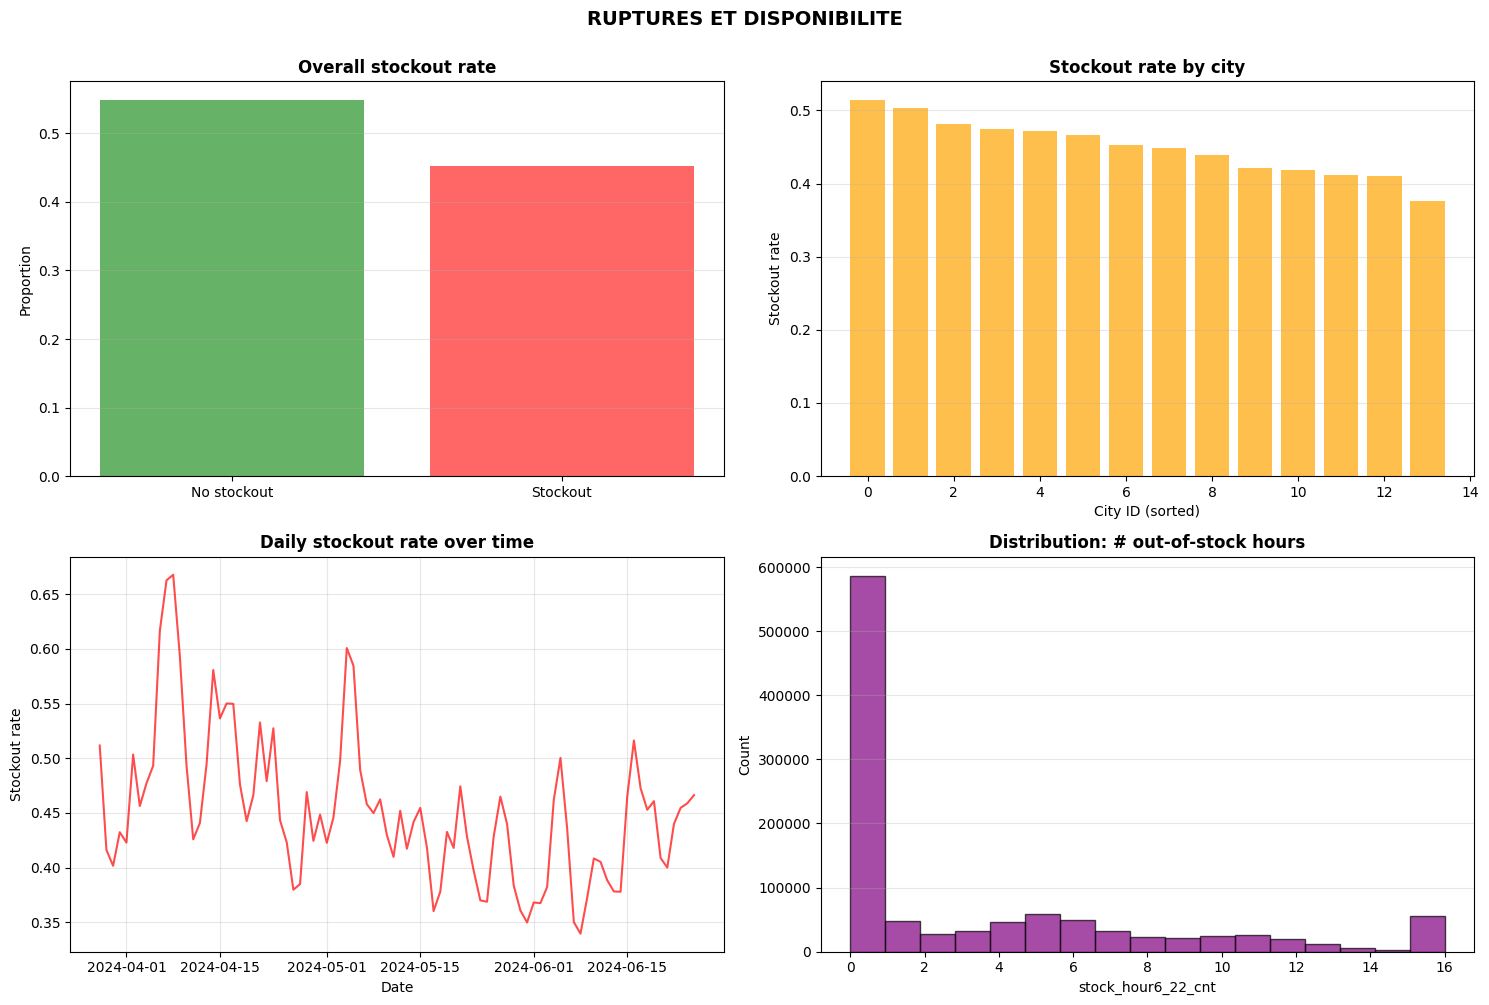


4. RUPTURE VS DEMANDE


/tmp/ipython-input-2205464182.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(data_boxplot, labels=["No stockout","Stockout"], showfliers=False)


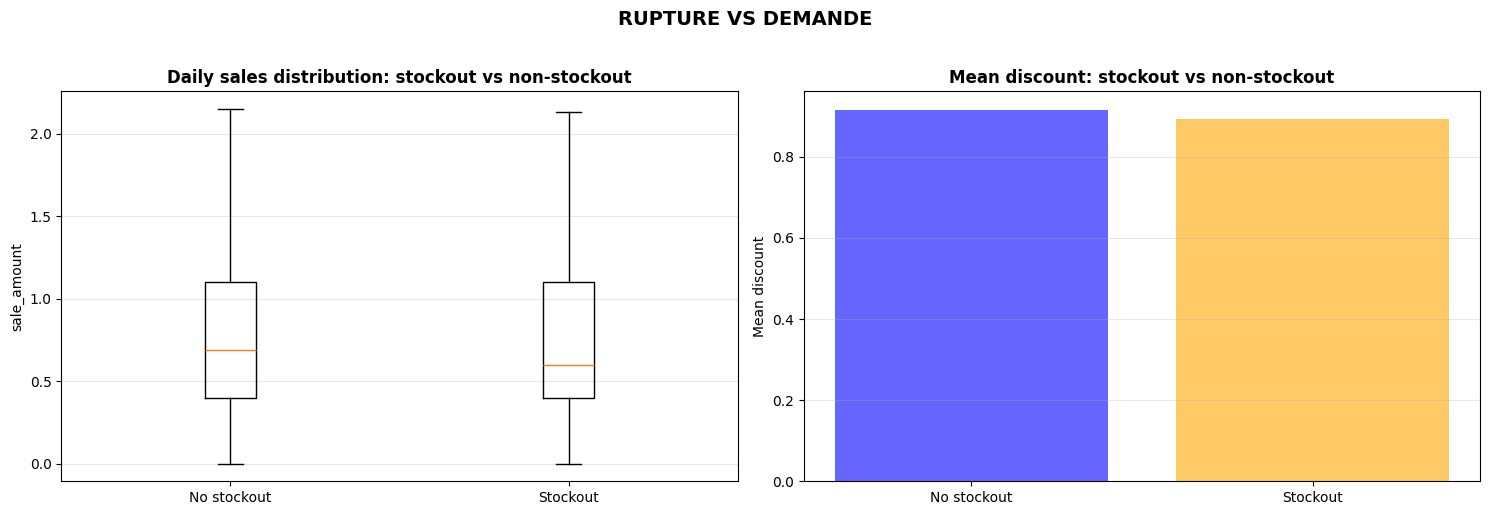


5. PROMOTIONS ET CONTEXTE


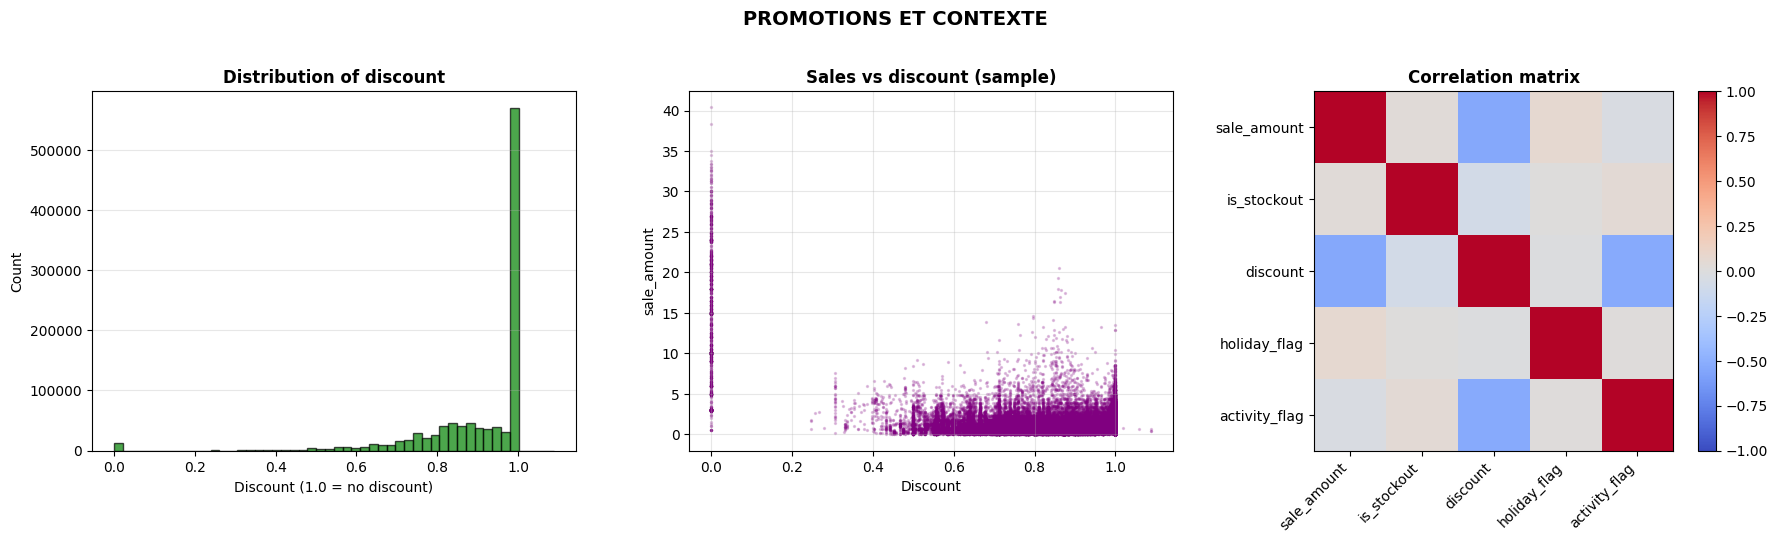


6. IMPACT HOLIDAY & ACTIVITY


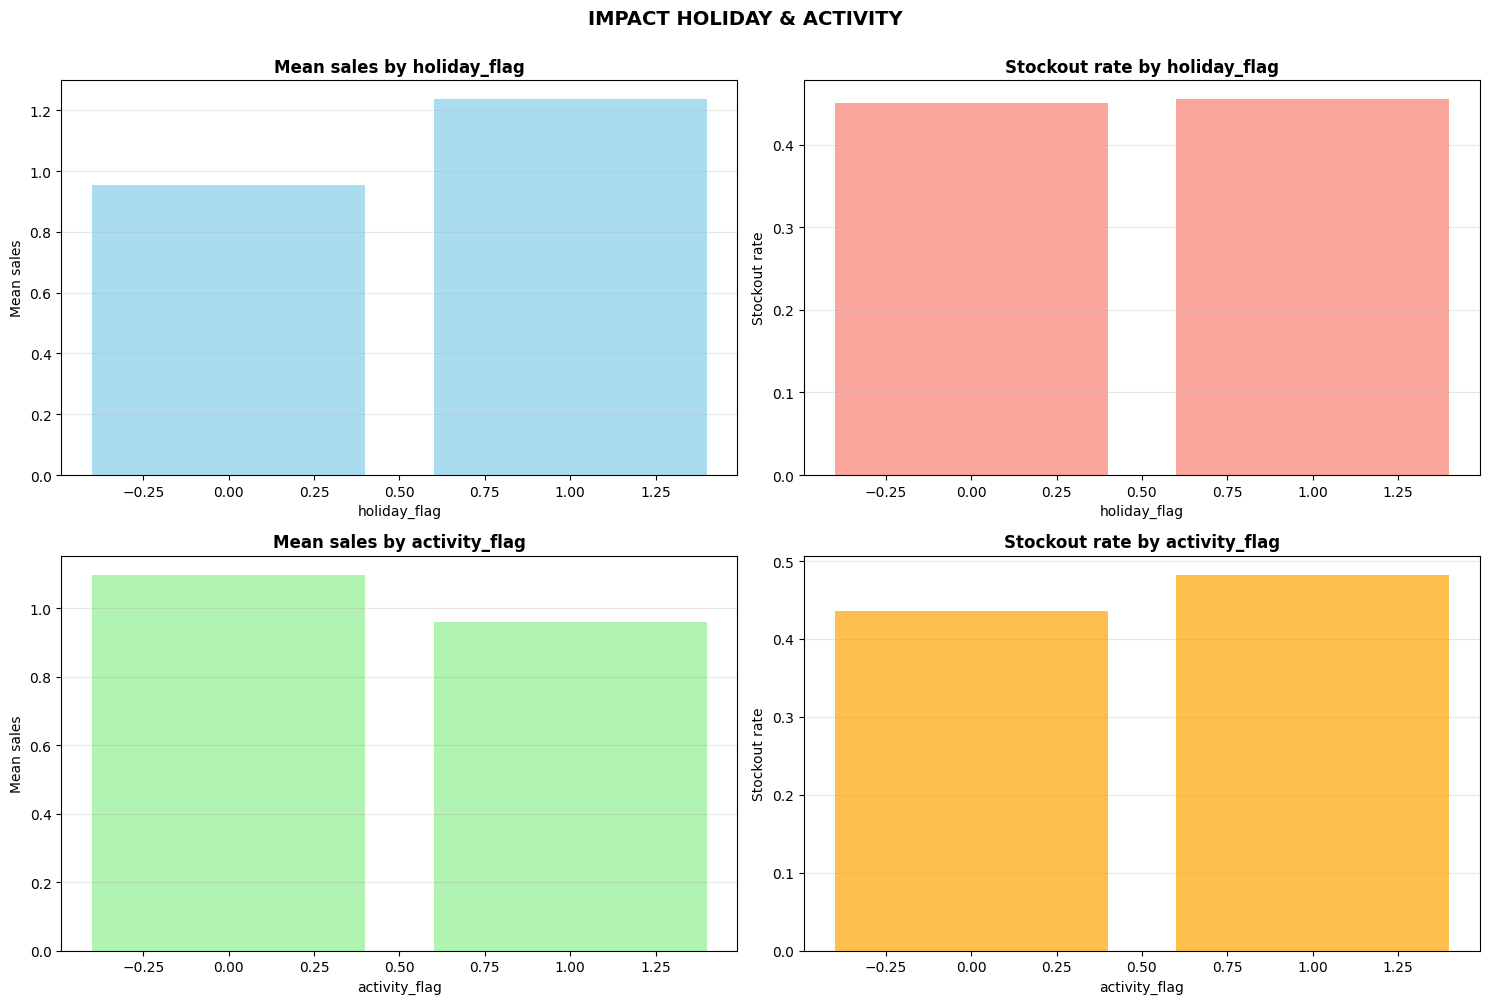


7. PROFILS HORAIRES


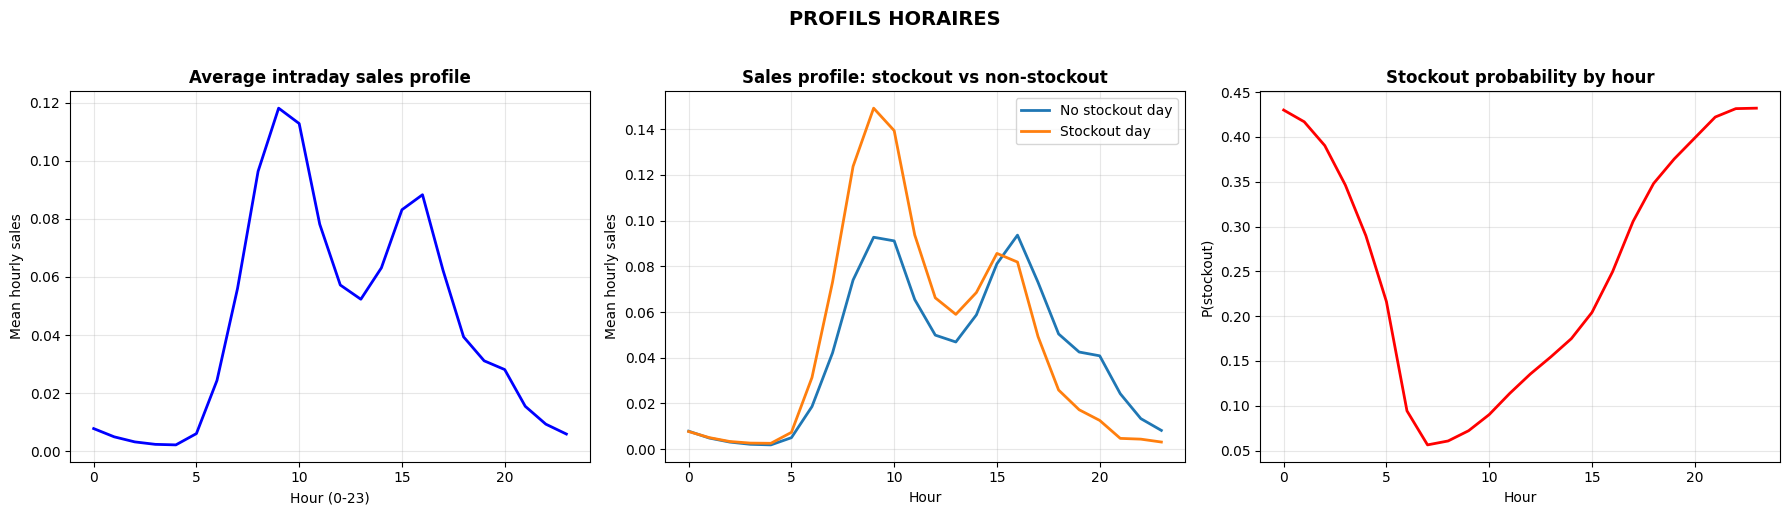


8. HETEROGENEITE PRODUITS/MAGASINS


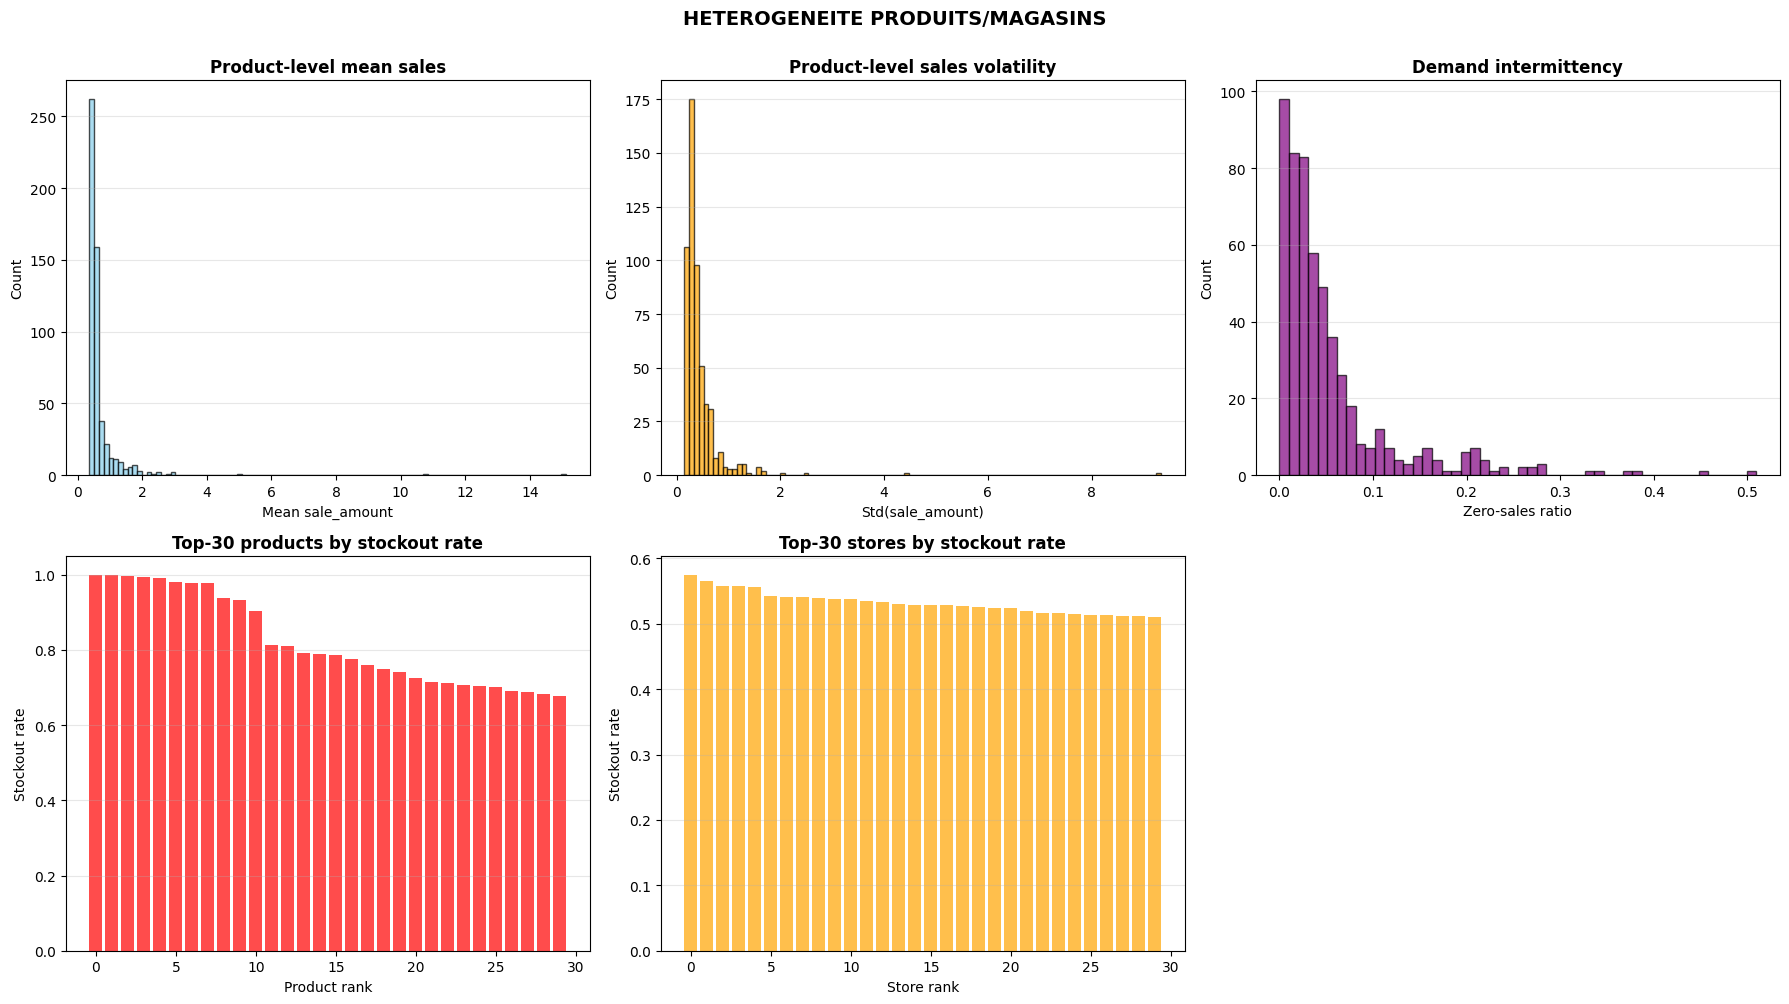

In [ ]:
# Configuration globale
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 10
PLOT_SAMPLE_N = 100000
RANDOM_SEED = 42

print(f"\nTraining set shape: {train_df.shape}")
print(f"Evaluation set shape: {eval_df.shape}")

for df in (train_df, eval_df):
    df["dt"] = pd.to_datetime(df["dt"])
    df["is_stockout"] = (df["stock_hour6_22_cnt"] > 0).astype(np.int8)
    df["dow"] = df["dt"].dt.dayofweek

def overview(df, name="train"):
    print(f"\n{name}:")
    print(f"  Rows: {len(df):,} | Cities: {df['city_id'].nunique()} | Stores: {df['store_id'].nunique()} | Products: {df['product_id'].nunique()}")
    print(f"  Period: {df['dt'].min()} -> {df['dt'].max()}")
    print(f"  Stockout rate: {df['is_stockout'].mean():.3%}")

overview(train_df, "train_df")
overview(eval_df, "eval_df")

print("\n" + "="*80)
print("1. ANALYSE GEOGRAPHIQUE")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ventes par ville
city_sales = train_df.groupby("city_id")["sale_amount"].sum().sort_values(ascending=False)
axes[0].bar(range(len(city_sales)), city_sales.values)
axes[0].set_title("Total sales volume by city", fontweight='bold')
axes[0].set_xlabel("City ID")
axes[0].set_ylabel("Total sales")
axes[0].grid(True, alpha=0.3)

# Magasins par ville
stores_by_city = train_df.groupby("city_id")["store_id"].nunique().sort_values(ascending=False)
axes[1].bar(range(len(stores_by_city)), stores_by_city.values)
axes[1].set_title("Number of stores by city", fontweight='bold')
axes[1].set_xlabel("City ID")
axes[1].set_ylabel("# stores")
axes[1].grid(True, alpha=0.3)

# Produits par ville
products_by_city = train_df.groupby("city_id")["product_id"].nunique().sort_values(ascending=False)
axes[2].bar(range(len(products_by_city)), products_by_city.values)
axes[2].set_title("Number of unique products by city", fontweight='bold')
axes[2].set_xlabel("City ID")
axes[2].set_ylabel("# products")
axes[2].grid(True, alpha=0.3)

plt.suptitle("ANALYSE GEOGRAPHIQUE", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("2. ANALYSE TEMPORELLE")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ventes totales par jour
daily_total_sales = train_df.groupby("dt")["sale_amount"].sum()
axes[0].plot(daily_total_sales.index, daily_total_sales.values)
axes[0].set_title("Total daily sales over time", fontweight='bold')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Total sales")
axes[0].grid(True, alpha=0.3)

# Ventes moyennes par jour
daily_mean_sales = train_df.groupby("dt")["sale_amount"].mean()
axes[1].plot(daily_mean_sales.index, daily_mean_sales.values)
axes[1].set_title("Mean daily sales over time", fontweight='bold')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Mean sales")
axes[1].grid(True, alpha=0.3)

# Pattern hebdomadaire
dow_sales = train_df.groupby("dow")["sale_amount"].mean()
axes[2].bar(dow_sales.index, dow_sales.values)
axes[2].set_title("Mean sales by day-of-week", fontweight='bold')
axes[2].set_xlabel("Day (0=Mon, 6=Sun)")
axes[2].set_ylabel("Mean sales")
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle("ANALYSE TEMPORELLE", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
print("\n" + "="*80)
print("3. RUPTURES ET DISPONIBILITE")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Taux global de rupture
stockout_rate = train_df["is_stockout"].mean()
axes[0, 0].bar(["No stockout", "Stockout"], [1-stockout_rate, stockout_rate], color=['green', 'red'], alpha=0.6)
axes[0, 0].set_title("Overall stockout rate", fontweight='bold')
axes[0, 0].set_ylabel("Proportion")
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Taux de rupture par ville
city_stockout = train_df.groupby("city_id")["is_stockout"].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(city_stockout)), city_stockout.values, color='orange', alpha=0.7)
axes[0, 1].set_title("Stockout rate by city", fontweight='bold')
axes[0, 1].set_xlabel("City ID (sorted)")
axes[0, 1].set_ylabel("Stockout rate")
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Taux de rupture dans le temps
daily_stockout_rate = train_df.groupby("dt")["is_stockout"].mean()
axes[1, 0].plot(daily_stockout_rate.index, daily_stockout_rate.values, color='red', alpha=0.7)
axes[1, 0].set_title("Daily stockout rate over time", fontweight='bold')
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Stockout rate")
axes[1, 0].grid(True, alpha=0.3)

# Distribution heures de rupture
axes[1, 1].hist(train_df["stock_hour6_22_cnt"], bins=17, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title("Distribution: # out-of-stock hours", fontweight='bold')
axes[1, 1].set_xlabel("stock_hour6_22_cnt")
axes[1, 1].set_ylabel("Count")
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle("RUPTURES ET DISPONIBILITE", fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("4. RUPTURE VS DEMANDE")
print("="*80)

sample_df = train_df.sample(n=min(PLOT_SAMPLE_N, len(train_df)), random_state=RANDOM_SEED)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot ventes par statut rupture
data_boxplot = [
    sample_df.loc[sample_df["is_stockout"]==0, "sale_amount"].dropna(),
    sample_df.loc[sample_df["is_stockout"]==1, "sale_amount"].dropna()
]
axes[0].boxplot(data_boxplot, labels=["No stockout","Stockout"], showfliers=False)
axes[0].set_title("Daily sales distribution: stockout vs non-stockout", fontweight='bold')
axes[0].set_ylabel("sale_amount")
axes[0].grid(True, alpha=0.3, axis='y')

# Discount moyen par statut
disc_by_stockout = train_df.groupby("is_stockout")["discount"].mean()
axes[1].bar(["No stockout", "Stockout"], disc_by_stockout.values, color=['blue', 'orange'], alpha=0.6)
axes[1].set_title("Mean discount: stockout vs non-stockout", fontweight='bold')
axes[1].set_ylabel("Mean discount")
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle("RUPTURE VS DEMANDE", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("5. PROMOTIONS ET CONTEXTE")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution discount
axes[0].hist(train_df["discount"].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0].set_title("Distribution of discount", fontweight='bold')
axes[0].set_xlabel("Discount (1.0 = no discount)")
axes[0].set_ylabel("Count")
axes[0].grid(True, alpha=0.3, axis='y')

# Ventes vs discount
axes[1].scatter(sample_df["discount"], sample_df["sale_amount"], s=2, alpha=0.2, c='purple')
axes[1].set_title("Sales vs discount (sample)", fontweight='bold')
axes[1].set_xlabel("Discount")
axes[1].set_ylabel("sale_amount")
axes[1].grid(True, alpha=0.3)

# Correlation matrix
corr_cols = ["sale_amount", "is_stockout", "discount", "holiday_flag", "activity_flag"]
corr = train_df[corr_cols].corr(numeric_only=True)
im = axes[2].imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_xticks(range(len(corr.columns)))
axes[2].set_yticks(range(len(corr.index)))
axes[2].set_xticklabels(corr.columns, rotation=45, ha='right')
axes[2].set_yticklabels(corr.index)
axes[2].set_title("Correlation matrix", fontweight='bold')
plt.colorbar(im, ax=axes[2])

plt.suptitle("PROMOTIONS ET CONTEXTE", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("6. IMPACT HOLIDAY & ACTIVITY")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Holiday: ventes et ruptures
holiday_sales = train_df.groupby("holiday_flag")["sale_amount"].mean()
holiday_stockout = train_df.groupby("holiday_flag")["is_stockout"].mean()

axes[0, 0].bar(holiday_sales.index, holiday_sales.values, color='skyblue', alpha=0.7)
axes[0, 0].set_title("Mean sales by holiday_flag", fontweight='bold')
axes[0, 0].set_xlabel("holiday_flag")
axes[0, 0].set_ylabel("Mean sales")
axes[0, 0].grid(True, alpha=0.3, axis='y')

axes[0, 1].bar(holiday_stockout.index, holiday_stockout.values, color='salmon', alpha=0.7)
axes[0, 1].set_title("Stockout rate by holiday_flag", fontweight='bold')
axes[0, 1].set_xlabel("holiday_flag")
axes[0, 1].set_ylabel("Stockout rate")
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Activity: ventes et ruptures
activity_sales = train_df.groupby("activity_flag")["sale_amount"].mean()
activity_stockout = train_df.groupby("activity_flag")["is_stockout"].mean()

axes[1, 0].bar(activity_sales.index, activity_sales.values, color='lightgreen', alpha=0.7)
axes[1, 0].set_title("Mean sales by activity_flag", fontweight='bold')
axes[1, 0].set_xlabel("activity_flag")
axes[1, 0].set_ylabel("Mean sales")
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].bar(activity_stockout.index, activity_stockout.values, color='orange', alpha=0.7)
axes[1, 1].set_title("Stockout rate by activity_flag", fontweight='bold')
axes[1, 1].set_xlabel("activity_flag")
axes[1, 1].set_ylabel("Stockout rate")
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle("IMPACT HOLIDAY & ACTIVITY", fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("7. PROFILS HORAIRES")
print("="*80)

sample_df = train_df.sample(n=min(200_000, len(train_df)), random_state=RANDOM_SEED)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Profil horaire moyen
hours_sale_mat = np.vstack(sample_df["hours_sale"].values).astype(np.float32)
mean_hourly_sale = hours_sale_mat.mean(axis=0)
axes[0].plot(mean_hourly_sale, linewidth=2, color='blue')
axes[0].set_title("Average intraday sales profile", fontweight='bold')
axes[0].set_xlabel("Hour (0-23)")
axes[0].set_ylabel("Mean hourly sales")
axes[0].grid(True, alpha=0.3)

# Profil conditionné: stockout vs non-stockout
mat_sale = np.vstack(sample_df["hours_sale"].values).astype(np.float32)
mask_so = sample_df["is_stockout"].values.astype(bool)
mean_sale_no = mat_sale[~mask_so].mean(axis=0)
mean_sale_so = mat_sale[mask_so].mean(axis=0)

axes[1].plot(mean_sale_no, label="No stockout day", linewidth=2)
axes[1].plot(mean_sale_so, label="Stockout day", linewidth=2)
axes[1].set_title("Sales profile: stockout vs non-stockout", fontweight='bold')
axes[1].set_xlabel("Hour")
axes[1].set_ylabel("Mean hourly sales")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Probabilité de rupture par heure
mat_stock = np.vstack(sample_df["hours_stock_status"].values).astype(np.int8)
stockout_hour_rate = mat_stock.mean(axis=0)
axes[2].plot(stockout_hour_rate, linewidth=2, color='red')
axes[2].set_title("Stockout probability by hour", fontweight='bold')
axes[2].set_xlabel("Hour")
axes[2].set_ylabel("P(stockout)")
axes[2].grid(True, alpha=0.3)

plt.suptitle("PROFILS HORAIRES", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("8. HETEROGENEITE PRODUITS/MAGASINS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Distribution ventes moyennes par produit
prod_mean = train_df.groupby("product_id")["sale_amount"].mean()
axes[0, 0].hist(prod_mean, bins=100, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title("Product-level mean sales", fontweight='bold')
axes[0, 0].set_xlabel("Mean sale_amount")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Volatilité par produit
prod_std = train_df.groupby("product_id")["sale_amount"].std()
axes[0, 1].hist(prod_std, bins=100, color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].set_title("Product-level sales volatility", fontweight='bold')
axes[0, 1].set_xlabel("Std(sale_amount)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Intermittence (jours à 0)
zero_ratio = train_df.groupby("product_id")["sale_amount"].apply(lambda s: (s == 0).mean())
axes[0, 2].hist(zero_ratio, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 2].set_title("Demand intermittency", fontweight='bold')
axes[0, 2].set_xlabel("Zero-sales ratio")
axes[0, 2].set_ylabel("Count")
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Top 30 produits par rupture
prod_stockout = train_df.groupby("product_id")["is_stockout"].mean().sort_values(ascending=False).head(30)
axes[1, 0].bar(range(len(prod_stockout)), prod_stockout.values, color='red', alpha=0.7)
axes[1, 0].set_title("Top-30 products by stockout rate", fontweight='bold')
axes[1, 0].set_xlabel("Product rank")
axes[1, 0].set_ylabel("Stockout rate")
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Top 30 magasins par rupture
store_stockout = train_df.groupby("store_id")["is_stockout"].mean().sort_values(ascending=False).head(30)
axes[1, 1].bar(range(len(store_stockout)), store_stockout.values, color='orange', alpha=0.7)
axes[1, 1].set_title("Top-30 stores by stockout rate", fontweight='bold')
axes[1, 1].set_xlabel("Store rank")
axes[1, 1].set_ylabel("Stockout rate")
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Vide (pour symétrie)
axes[1, 2].axis('off')

plt.suptitle("HETEROGENEITE PRODUITS/MAGASINS", fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


This EDA characterizes FreshRetailNet-50K as a multi-granularity retail dataset combining:
- daily outcomes with hourly behavioral signatures,
- explicit stockout annotations,
- contextual drivers such as promotions, calendar flags, and weather.

Key findings:
1) Demand and stock availability vary strongly across cities, stores, and products (high heterogeneity).
2) Stockouts are non-uniform over time, with peaks suggesting stress periods.
3) Hourly signals provide unique information beyond daily sales, enabling intraday operational insights.
4) Promotions are associated with demand shifts and increased stockout risk.
5) Demand intermittency varies widely across products, motivating segmentation and task-specific modeling choices.

**Prédiction de la demande potentielle**

L’objectif de cette étape est d’estimer la demande réelle des produits. Pour cela, nous utilisons uniquement les observations sans rupture de stock (stock-out), car dans ce cas les ventes observées correspondent directement à la demande réelle.

La prédiction de la demande potentielle est réalisée à l’aide de quatre modèles de machine learning, qui seront comparés sur la base de la métrique MSA. Les modèles utilisés sont :
1.   LightGBM
2.   XGBoost
3.   Random Forest
2.   Réseau de neurones MLP



**Modèle 1** : LightGBM

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[2738]	train's rmse: 0.182431	valid's rmse: 0.212667
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[2110]	train's rmse: 0.184037	valid's rmse: 0.212791
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[2823]	train's rmse: 0.182299	valid's rmse: 0.211995

 TRAIN: MAE=0.2983 RMSE=0.4984 R²=0.8752
EVAL : MAE=0.3698 RMSE=0.9297 R²=0.9159
Ratio Eval/Train RMSE: 1.87x

 TOP 10 FEATURES
              feature  importance
           product_id        4036
    third_category_id        1951
             store_id        1907
days_since_year_start        1715
             discount        1669
    store_product_avg        1433
       rolling_mean_7         767
         week_of_year         656
   discount_x_holiday         625
                lag_1         610


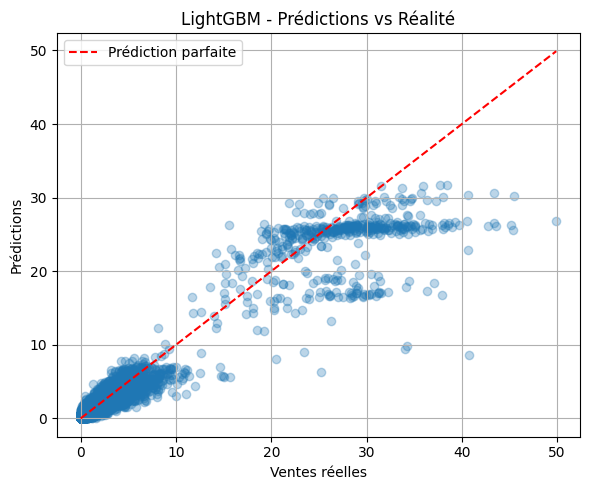

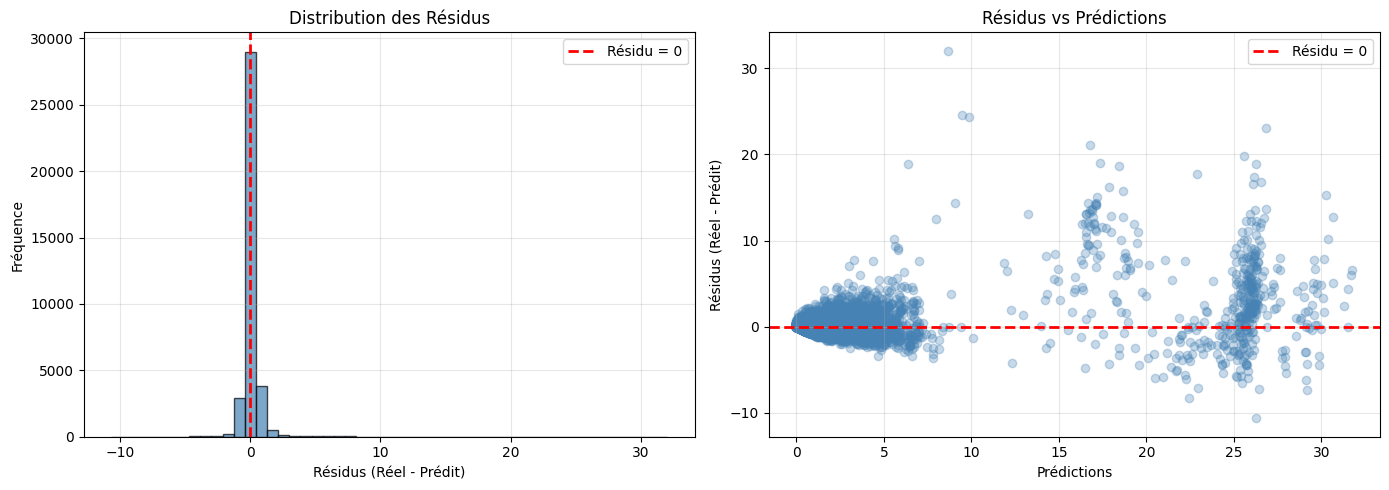


=== STATISTIQUES DES RÉSIDUS ===
Moyenne des résidus : 0.0905
Écart-type des résidus : 0.9253
Résidu min : -10.6500
Résidu max : 32.0385
Médiane des résidus : -0.0106


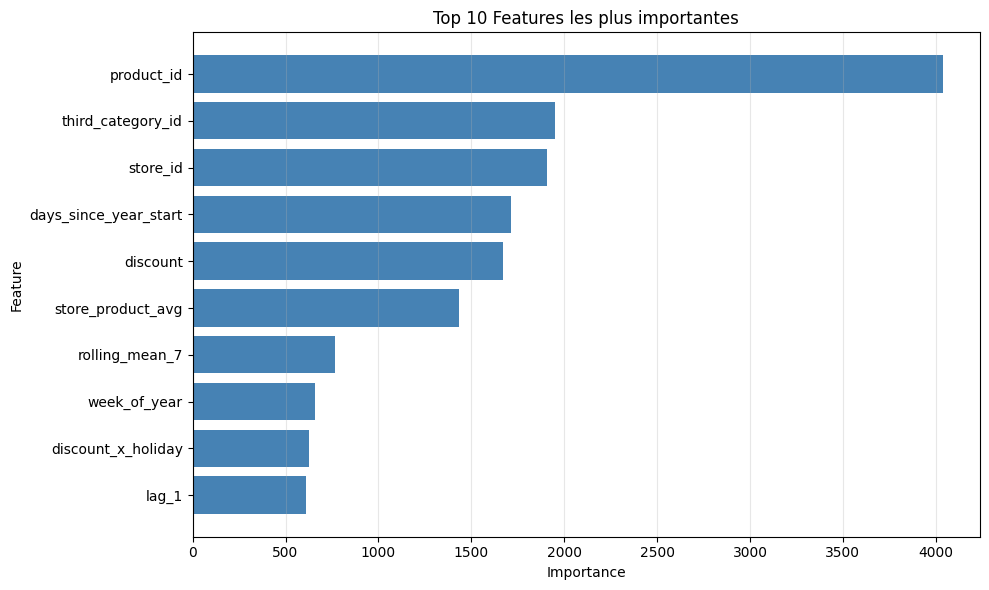

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train_df['dt'] = pd.to_datetime(train_df['dt'])
eval_df['dt'] = pd.to_datetime(eval_df['dt'])

# Time features minimalistes
def add_time_features(df):
    df = df.copy()
    df['month'] = df['dt'].dt.month
    df['dayofweek'] = df['dt'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['week_of_year'] = df['dt'].dt.isocalendar().week
    df['days_since_year_start'] = df['dt'].dt.dayofyear
    return df

train_df = add_time_features(train_df)
eval_df = add_time_features(eval_df)

# Filter days without stockout
def filter_days_no_stockout(df):
    return df[df['hours_stock_status'].apply(lambda x: all(h == 0 for h in x))].copy()

train_clean = filter_days_no_stockout(train_df)
eval_clean = filter_days_no_stockout(eval_df)

# Lag features minimalistes
def add_minimal_lags(df, group_cols, target_col):
    df = df.sort_values(group_cols + ['dt']).copy()
    for lag in [1, 7, 14]:
        df[f'lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)
    df['trend_7'] = (df.groupby(group_cols)[target_col].shift(1) -
                      df.groupby(group_cols)[target_col].shift(7)) / 7
    df['rolling_mean_7'] = df.groupby(group_cols)[target_col].shift(1).rolling(7, min_periods=3).mean()
    df['rolling_std_7'] = df.groupby(group_cols)[target_col].shift(1).rolling(7, min_periods=3).std()
    df['cv_7'] = df['rolling_std_7'] / (df['rolling_mean_7'] + 1)
    return df

train_clean = add_minimal_lags(train_clean, ['store_id', 'product_id'], 'sale_amount')
eval_clean = add_minimal_lags(eval_clean, ['store_id', 'product_id'], 'sale_amount')

# Aggregates simplifiées
def add_aggregates(df):
    df = df.copy()
    product_avg = df.groupby('product_id')['sale_amount'].mean()
    df['product_avg_sales'] = df['product_id'].map(product_avg)
    store_product_avg = df.groupby(['store_id','product_id'])['sale_amount'].mean()
    df['store_product_avg'] = df.set_index(['store_id','product_id']).index.map(store_product_avg)
    dow_avg = df.groupby('dayofweek')['sale_amount'].mean()
    df['dow_avg_sales'] = df['dayofweek'].map(dow_avg)
    return df

train_clean = add_aggregates(train_clean)
eval_clean = add_aggregates(eval_clean)

# Interaction features
train_clean['discount_x_holiday'] = train_clean['discount'] * train_clean['holiday_flag']
train_clean['lag1_ratio_mean7'] = train_clean['lag_1'] / (train_clean['rolling_mean_7'] + 1)
eval_clean['discount_x_holiday'] = eval_clean['discount'] * eval_clean['holiday_flag']
eval_clean['lag1_ratio_mean7'] = eval_clean['lag_1'] / (eval_clean['rolling_mean_7'] + 1)

# Handle missing values
lag_cols = [c for c in train_clean.columns if any(x in c for x in ['lag_', 'rolling_', 'trend_', 'cv_', 'ratio'])]
for col in lag_cols:
    train_clean[col] = train_clean.groupby(['store_id', 'product_id'])[col].transform(
        lambda x: x.fillna(x.median()) if x.notna().any() else x
    ).fillna(train_clean[col].median())
    eval_clean[col] = eval_clean.groupby(['store_id', 'product_id'])[col].transform(
        lambda x: x.fillna(x.median()) if x.notna().any() else x
    ).fillna(train_clean[col].median())
train_clean = train_clean.fillna(0)
eval_clean = eval_clean.fillna(0)

# Features
categorical_features = ['store_id','product_id','third_category_id']
numerical_features = [
    'month','dayofweek','is_weekend','week_of_year','days_since_year_start',
    'lag_1','lag_7','lag_14','trend_7','rolling_mean_7','rolling_std_7','cv_7',
    'product_avg_sales','store_product_avg','dow_avg_sales',
    'discount','holiday_flag','discount_x_holiday','lag1_ratio_mean7'
]
feature_cols = numerical_features + categorical_features

# Split 75/25 pour validation stricte
train_clean = train_clean.sort_values('dt')
split_idx = int(len(train_clean) * 0.75)
X_train_split = train_clean.iloc[:split_idx][feature_cols]
y_train_split = np.log1p(train_clean.iloc[:split_idx]['sale_amount'])
X_val_split = train_clean.iloc[split_idx:][feature_cols]
y_val_split = np.log1p(train_clean.iloc[split_idx:]['sale_amount'])
X_train_full = train_clean[feature_cols]
y_train_full = np.log1p(train_clean['sale_amount'])
X_eval = eval_clean[feature_cols]
y_eval = np.log1p(eval_clean['sale_amount'])

# LightGBM hyperparamètres conservateurs
lgb_params_final = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 10,       # plus conservatif
    'max_depth': 3,         # réduit
    'min_data_in_leaf': 500,# plus robuste
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'lambda_l1': 3.0,       # régularisation forte
    'lambda_l2': 3.0,
    'min_gain_to_split': 0.1,
    'max_bin': 128,
    'verbosity': -1,
    'random_state': 42,
    'n_jobs': -1
}

# Bagging 3 modèles
bagging_preds_train = np.zeros(len(X_train_full))
bagging_preds_eval = np.zeros(len(X_eval))

for seed in [42, 52, 62]:
    lgb_params_final['random_state'] = seed
    model = lgb.LGBMRegressor(**lgb_params_final, n_estimators=5000)
    model.fit(
        X_train_split, y_train_split,
        eval_set=[(X_train_split, y_train_split),(X_val_split, y_val_split)],
        eval_names=['train','valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=250)],
        categorical_feature=categorical_features
    )
    # Retrain full data
    final_model = lgb.LGBMRegressor(**lgb_params_final, n_estimators=model.best_iteration_)
    final_model.fit(X_train_full, y_train_full, categorical_feature=categorical_features)

    bagging_preds_train += np.expm1(final_model.predict(X_train_full))
    bagging_preds_eval += np.expm1(final_model.predict(X_eval))

bagging_preds_train /= 3
bagging_preds_eval /= 3

# Clip négatifs
bagging_preds_train = np.maximum(bagging_preds_train, 0)
bagging_preds_eval = np.maximum(bagging_preds_eval, 0)

# Evaluation
train_mae = mean_absolute_error(train_clean['sale_amount'], bagging_preds_train)
train_rmse = np.sqrt(mean_squared_error(train_clean['sale_amount'], bagging_preds_train))
train_r2 = r2_score(train_clean['sale_amount'], bagging_preds_train)

eval_mae = mean_absolute_error(eval_clean['sale_amount'], bagging_preds_eval)
eval_rmse = np.sqrt(mean_squared_error(eval_clean['sale_amount'], bagging_preds_eval))
eval_r2 = r2_score(eval_clean['sale_amount'], bagging_preds_eval)

ratio = eval_rmse / train_rmse

print(f"\n TRAIN: MAE={train_mae:.4f} RMSE={train_rmse:.4f} R²={train_r2:.4f}")
print(f"EVAL : MAE={eval_mae:.4f} RMSE={eval_rmse:.4f} R²={eval_r2:.4f}")
print(f"Ratio Eval/Train RMSE: {ratio:.2f}x")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n TOP 10 FEATURES")
print(feature_importance.head(10).to_string(index=False))

# ============================================================================
# VISUALISATION DES PRÉDICTIONS
# ============================================================================

# Dictionnaire des modèles (pour l'instant uniquement LightGBM)
models = {
    "LightGBM": {"y_true": eval_clean['sale_amount'], "y_pred": bagging_preds_eval}
}

# Nombre de modèles
n_models = len(models)

# Crée la figure avec 1 ligne et n colonnes
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

# Si un seul modèle, axes n'est pas une liste, donc on le transforme
if n_models == 1:
    axes = [axes]

# Boucle sur chaque modèle
for i, (model_name, data) in enumerate(models.items()):
    y_true = data["y_true"]
    y_pred = data["y_pred"]

    axes[i].scatter(y_true, y_pred, alpha=0.3)
    axes[i].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()], 'r--', label='Prédiction parfaite')
    axes[i].set_xlabel("Ventes réelles")
    axes[i].set_ylabel("Prédictions")
    axes[i].set_title(f"{model_name} - Prédictions vs Réalité")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# ANALYSE DES RÉSIDUS
# ============================================================================

# Calculer les résidus
residuals = eval_clean['sale_amount'] - bagging_preds_eval

# Créer une figure avec 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distribution des résidus
axes[0].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
axes[0].set_xlabel('Résidus (Réel - Prédit)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des Résidus')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2: Résidus vs Prédictions
axes[1].scatter(bagging_preds_eval, residuals, alpha=0.3, color='steelblue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
axes[1].set_xlabel('Prédictions')
axes[1].set_ylabel('Résidus (Réel - Prédit)')
axes[1].set_title('Résidus vs Prédictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# STATISTIQUES SUR LES RÉSIDUS
# ============================================================================
print("\n=== STATISTIQUES DES RÉSIDUS ===")
print(f"Moyenne des résidus : {residuals.mean():.4f}")
print(f"Écart-type des résidus : {residuals.std():.4f}")
print(f"Résidu min : {residuals.min():.4f}")
print(f"Résidu max : {residuals.max():.4f}")
print(f"Médiane des résidus : {np.median(residuals):.4f}")

# ============================================================================
# IMPORTANCE DES TOP 10 FEATURES
# ============================================================================

# Récupérer les 10 features les plus importantes
top_10_importance = feature_importance.head(10)

# Créer le graphique d'importance
fig, ax = plt.subplots(figsize=(10, 6))

# Barplot horizontal pour mieux lire les noms de features
ax.barh(range(len(top_10_importance)), top_10_importance['importance'], color='steelblue')
ax.set_yticks(range(len(top_10_importance)))
ax.set_yticklabels(top_10_importance['feature'])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Top 10 Features les plus importantes')
ax.grid(True, alpha=0.3, axis='x')

# Inverser l'axe y pour avoir la feature la plus importante en haut
ax.invert_yaxis()

plt.tight_layout()
plt.show()

**Modèle 2 : XGBoost**

Création des features temporelles...

=== FILTRAGE DES JOURS SANS RUPTURE ===
Train sans rupture: 422924/1070640 lignes (39.5%)
Eval sans rupture: 37028/83272 lignes (44.5%)
Ajout des features de décalage...
Ajout des features métier...

=== GESTION DES VALEURS MANQUANTES ===
Valeurs manquantes après traitement - Train: 0
Valeurs manquantes après traitement - Eval: 0

=== SÉLECTION DES FEATURES ===
Features totales: 41
- Catégorielles: 6
- Numériques: 35

=== ENCODAGE CATÉGORIEL ===
  store_id: 311 classes
  product_id: 533 classes
  third_category_id: 180 classes
  city_id: 14 classes
  first_category_id: 28 classes
  second_category_id: 68 classes

=== SPLIT TEMPOREL ===
Train: 338339 lignes (jusqu'au 2024-06-09)
Validation: 84585 lignes (du 2024-06-09 au 2024-06-25)
Eval: 37028 lignes

=== CONFIGURATION DU MODÈLE ===
Entraînement en cours...
[0]	validation_0-rmse:1.21106	validation_0-mae:0.62822	validation_1-rmse:1.81620	validation_1-mae:0.71451
[50]	validation_0-rmse:0.45373	valida

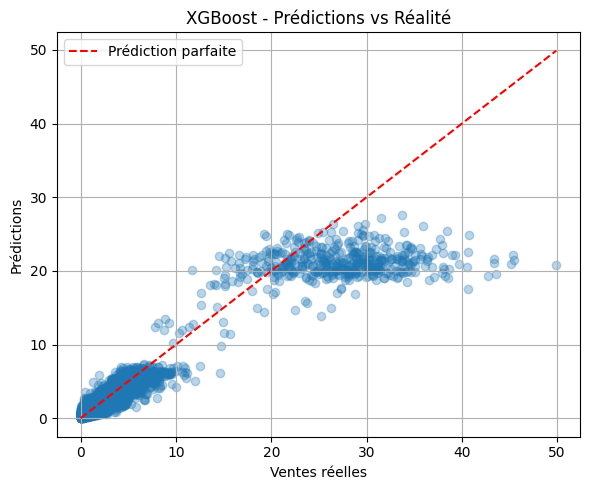

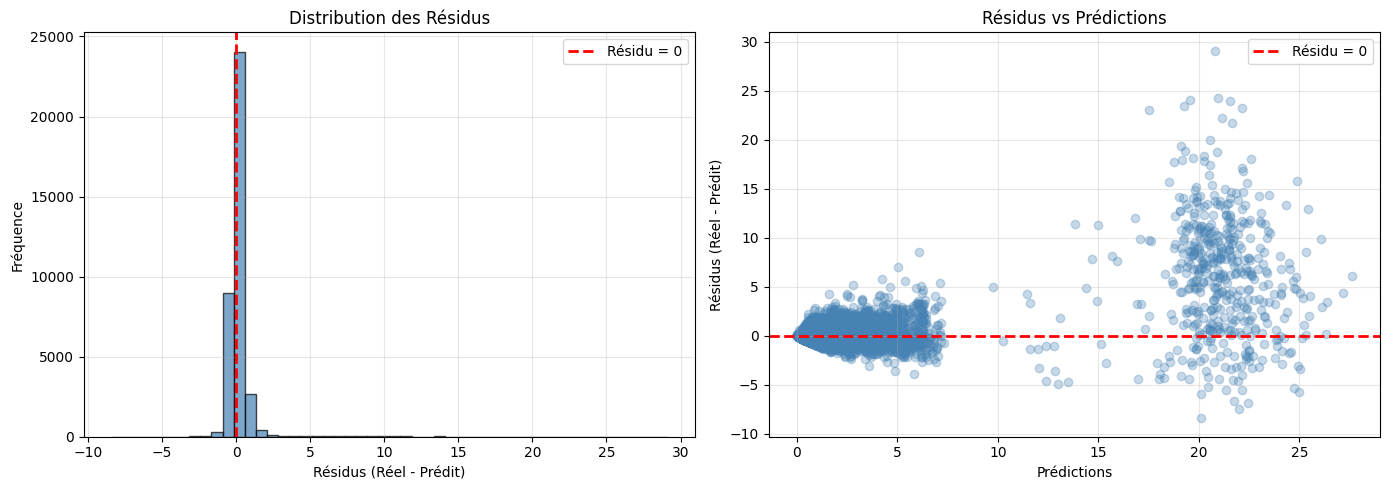


=== STATISTIQUES DES RÉSIDUS ===
Moyenne des résidus : 0.1487
Écart-type des résidus : 1.0748
Résidu min : -8.4178
Résidu max : 29.1061
Médiane des résidus : 0.0182


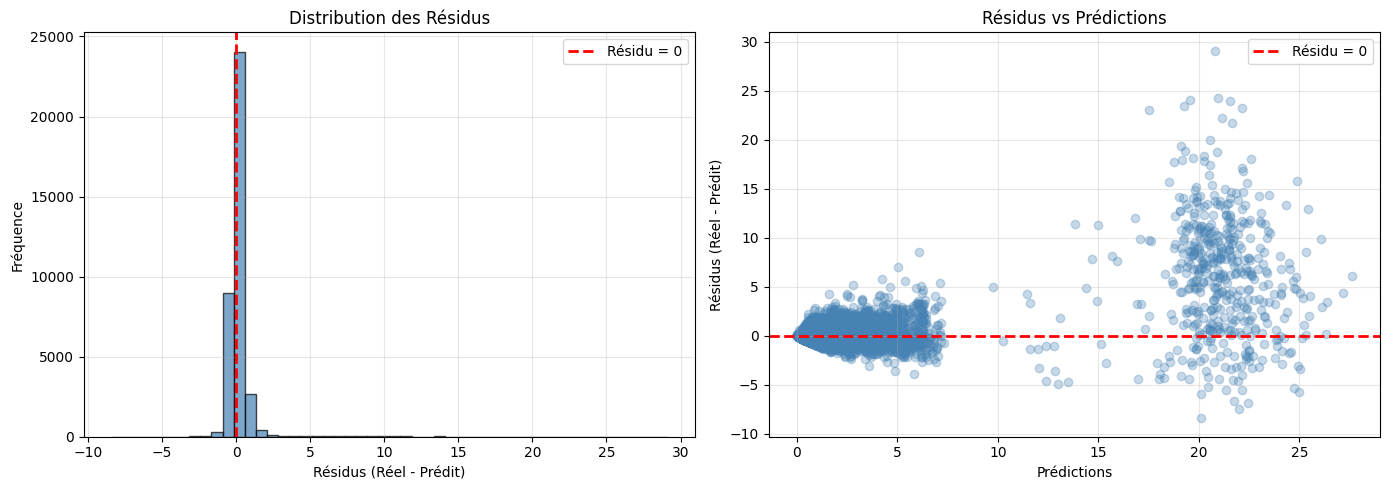


=== STATISTIQUES DES RÉSIDUS ===
Moyenne des résidus : 0.1487
Écart-type des résidus : 1.0748
Résidu min : -8.4178
Résidu max : 29.1061
Médiane des résidus : 0.0182


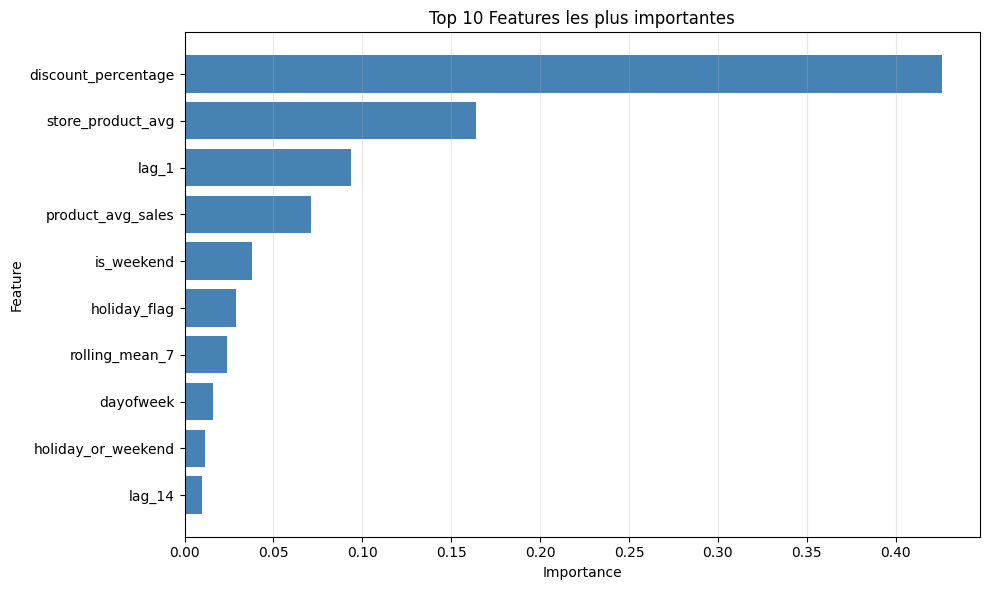

In [ ]:
import xgboost as xgb
# ============================================
# 4. FEATURES TEMPORELLES OPTIMISÉES
# ============================================
def add_time_features(df):
    df = df.copy()
    df['month'] = df['dt'].dt.month
    df['dayofweek'] = df['dt'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['week_of_year'] = df['dt'].dt.isocalendar().week.astype(int)
    df['day_of_year'] = df['dt'].dt.dayofyear
    df['quarter'] = df['dt'].dt.quarter
    df['day_of_month'] = df['dt'].dt.day
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df

print("Création des features temporelles...")
train_df = add_time_features(train_df)
eval_df = add_time_features(eval_df)

# ============================================
# 5. FILTRAGE DES JOURS SANS RUPTURE
# ============================================
print("\n=== FILTRAGE DES JOURS SANS RUPTURE ===")
def filter_days_no_stockout(df):
    return df[df['hours_stock_status'].apply(lambda x: all(h == 0 for h in x))].copy()

train_clean = filter_days_no_stockout(train_df)
eval_clean = filter_days_no_stockout(eval_df)

print(f"Train sans rupture: {len(train_clean)}/{len(train_df)} lignes ({len(train_clean)/len(train_df)*100:.1f}%)")
print(f"Eval sans rupture: {len(eval_clean)}/{len(eval_df)} lignes ({len(eval_clean)/len(eval_df)*100:.1f}%)")

# ============================================
# 6. FEATURES DE DÉCALAGE (LAGS) OPTIMISÉES
# ============================================
def add_lag_features(df, group_cols, target_col):
    df = df.sort_values(group_cols + ['dt']).copy()
    for lag in [1, 7, 14]:
        df[f'lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)
    df['trend_7'] = (df.groupby(group_cols)[target_col].shift(1) - df.groupby(group_cols)[target_col].shift(7)) / 7
    df['rolling_mean_7'] = df.groupby(group_cols)[target_col].shift(1).rolling(7, min_periods=3).mean()
    df['rolling_std_7'] = df.groupby(group_cols)[target_col].shift(1).rolling(7, min_periods=3).std()
    df['cv_7'] = df['rolling_std_7'] / (df['rolling_mean_7'] + 1)
    return df

print("Ajout des features de décalage...")
train_clean = add_lag_features(train_clean, ['store_id', 'product_id'], 'sale_amount')
eval_clean = add_lag_features(eval_clean, ['store_id', 'product_id'], 'sale_amount')

# ============================================
# 7. AGRÉGATS ET FEATURES MÉTIER
# ============================================
def add_business_features(df):
    df = df.copy()
    product_avg = df.groupby('product_id')['sale_amount'].mean()
    df['product_avg_sales'] = df['product_id'].map(product_avg)
    store_product_avg = df.groupby(['store_id', 'product_id'])['sale_amount'].mean()
    df['store_product_avg'] = df.set_index(['store_id', 'product_id']).index.map(store_product_avg)
    dow_avg = df.groupby('dayofweek')['sale_amount'].mean()
    df['dow_avg_sales'] = df['dayofweek'].map(dow_avg)
    df['temp_humidity_index'] = (df['avg_temperature'] * df['avg_humidity'] / 100)
    df['weather_impact'] = (df['precpt'] + df['avg_wind_level'])
    df['discount_percentage'] = (1 - df['discount']) * 100
    df['is_discounted'] = (df['discount'] < 1.0).astype(int)
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
    df['discount_x_holiday'] = df['discount'] * df['holiday_flag']
    df['holiday_or_weekend'] = ((df['holiday_flag'] == 1) | (df['is_weekend'] == 1)).astype(int)
    df['lag1_ratio_mean7'] = df['lag_1'] / (df['rolling_mean_7'] + 1)
    return df

print("Ajout des features métier...")
train_clean = add_business_features(train_clean)
eval_clean = add_business_features(eval_clean)

# ============================================
# 8. GESTION DES VALEURS MANQUANTES
# ============================================
print("\n=== GESTION DES VALEURS MANQUANTES ===")
lag_cols = [c for c in train_clean.columns if any(x in c for x in ['lag_', 'rolling_', 'trend_', 'cv_', 'ratio'])]

for col in lag_cols:
    train_clean[col] = train_clean.groupby(['store_id', 'product_id'])[col].transform(
        lambda x: x.fillna(x.median()) if x.notna().any() else x
    ).fillna(train_clean[col].median())

    eval_clean[col] = eval_clean.groupby(['store_id', 'product_id'])[col].transform(
        lambda x: x.fillna(x.median()) if x.notna().any() else x
    ).fillna(train_clean[col].median())

train_clean = train_clean.fillna(0)
eval_clean = eval_clean.fillna(0)

print(f"Valeurs manquantes après traitement - Train: {train_clean.isnull().sum().sum()}")
print(f"Valeurs manquantes après traitement - Eval: {eval_clean.isnull().sum().sum()}")

# ============================================
# 9. SÉLECTION DES FEATURES FINALES
# ============================================
print("\n=== SÉLECTION DES FEATURES ===")
categorical_features = ['store_id', 'product_id', 'third_category_id', 'city_id', 'first_category_id', 'second_category_id']
numerical_features = ['month', 'dayofweek', 'is_weekend', 'week_of_year', 'day_of_year', 'quarter', 'day_of_month',
                     'dayofweek_sin', 'dayofweek_cos', 'lag_1', 'lag_7', 'lag_14', 'trend_7', 'rolling_mean_7',
                     'rolling_std_7', 'cv_7', 'product_avg_sales', 'store_product_avg', 'dow_avg_sales',
                     'temp_humidity_index', 'weather_impact', 'avg_temperature', 'avg_humidity', 'precpt',
                     'avg_wind_level', 'discount', 'discount_percentage', 'is_discounted', 'holiday_flag',
                     'activity_flag', 'discount_x_holiday', 'holiday_or_weekend', 'lag1_ratio_mean7', 'is_summer', 'is_winter']

available_cat = [f for f in categorical_features if f in train_clean.columns]
available_num = [f for f in numerical_features if f in train_clean.columns]
feature_cols = available_cat + available_num
TARGET = 'sale_amount'

print(f"Features totales: {len(feature_cols)}")
print(f"- Catégorielles: {len(available_cat)}")
print(f"- Numériques: {len(available_num)}")

# ============================================
# 10. ENCODAGE CATÉGORIEL
# ============================================
print("\n=== ENCODAGE CATÉGORIEL ===")
label_encoders = {}
for col in available_cat:
    le = LabelEncoder()
    train_clean[col] = le.fit_transform(train_clean[col].astype(str))
    eval_clean[col] = eval_clean[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} classes")

# ============================================
# 11. SPLIT TEMPOREL STRICT
# ============================================
print("\n=== SPLIT TEMPOREL ===")
train_clean = train_clean.sort_values('dt')
split_idx = int(len(train_clean) * 0.8)

train_part = train_clean.iloc[:split_idx].copy()
valid_part = train_clean.iloc[split_idx:].copy()

X_train = train_part[feature_cols]
y_train = train_part[TARGET]
X_valid = valid_part[feature_cols]
y_valid = valid_part[TARGET]
X_eval = eval_clean[feature_cols]
y_evalxgb = eval_clean[TARGET]

print(f"Train: {X_train.shape[0]} lignes (jusqu'au {train_part['dt'].max().date()})")
print(f"Validation: {X_valid.shape[0]} lignes (du {valid_part['dt'].min().date()} au {valid_part['dt'].max().date()})")
print(f"Eval: {X_eval.shape[0]} lignes")

# ============================================
# 12. MODÈLE XGBOOST OPTIMISÉ
# ============================================
print("\n=== CONFIGURATION DU MODÈLE ===")
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    eval_metric=['rmse', 'mae'],
    early_stopping_rounds=20
)

print("Entraînement en cours...")
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=50)

# ============================================
# 13. PRÉDICTIONS
# ============================================
y_pred_valid = model.predict(X_valid)
y_pred_eval = model.predict(X_eval)

# ============================================
# 14. ÉVALUATION SUR VALIDATION
# ============================================
print("\n=== ÉVALUATION SUR VALIDATION ===")
mae = mean_absolute_error(y_valid, y_pred_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
r2 = r2_score(y_valid, y_pred_valid)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"\nMétriques relatives:")
print(f"MAE relative: {mae/y_valid.mean()*100:.2f}% de la moyenne")
print(f"RMSE relative: {rmse/y_valid.mean()*100:.2f}% de la moyenne")

# ============================================
# 15. ÉVALUATION SUR EVAL
# ============================================
print("\n=== ÉVALUATION SUR EVAL ===")
mae_eval = mean_absolute_error(y_evalxgb, y_pred_eval)
rmse_eval = np.sqrt(mean_squared_error(y_evalxgb, y_pred_eval))
r2_eval = r2_score(y_evalxgb, y_pred_eval)

print(f"MAE: {mae_eval:.4f}")
print(f"RMSE: {rmse_eval:.4f}")
print(f"R²: {r2_eval:.4f}")

# ============================================
# 16. FEATURE IMPORTANCE
# ============================================
print("\n=== IMPORTANCE DES FEATURES ===")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 des features les plus importantes:")
for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    print(f"{i:2}. {row['feature']}: {row['importance']:.4f}")

# ============================================================================
# 17. VISUALISATION DES PRÉDICTIONS
# ============================================================================

# Dictionnaire des modèles
models = {
    "XGBoost": {"y_true": y_evalxgb, "y_pred": y_pred_eval}
}

# Nombre de modèles
n_models = len(models)

# Crée la figure avec 1 ligne et n colonnes
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

# Si un seul modèle, axes n'est pas une liste, donc on le transforme
if n_models == 1:
    axes = [axes]

# Boucle sur chaque modèle
for i, (model_name, data) in enumerate(models.items()):
    y_true = data["y_true"]
    y_pred = data["y_pred"]

    axes[i].scatter(y_true, y_pred, alpha=0.3)
    axes[i].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()], 'r--', label='Prédiction parfaite')
    axes[i].set_xlabel("Ventes réelles")
    axes[i].set_ylabel("Prédictions")
    axes[i].set_title(f"{model_name} - Prédictions vs Réalité")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# 19. ANALYSE DES RÉSIDUS
# ============================================================================

# Calculer les résidus
residuals = y_evalxgb - y_pred_eval

# Créer une figure avec 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distribution des résidus
axes[0].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
axes[0].set_xlabel('Résidus (Réel - Prédit)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des Résidus')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2: Résidus vs Prédictions
axes[1].scatter(y_pred_eval, residuals, alpha=0.3, color='steelblue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
axes[1].set_xlabel('Prédictions')
axes[1].set_ylabel('Résidus (Réel - Prédit)')
axes[1].set_title('Résidus vs Prédictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 20. STATISTIQUES SUR LES RÉSIDUS
# ============================================================================
print("\n=== STATISTIQUES DES RÉSIDUS ===")
print(f"Moyenne des résidus : {residuals.mean():.4f}")
print(f"Écart-type des résidus : {residuals.std():.4f}")
print(f"Résidu min : {residuals.min():.4f}")
print(f"Résidu max : {residuals.max():.4f}")
print(f"Médiane des résidus : {np.median(residuals):.4f}")

# ============================================================================
# 19. ANALYSE DES RÉSIDUS
# ============================================================================

# Calculer les résidus
residuals = y_evalxgb - y_pred_eval

# Créer une figure avec 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distribution des résidus
axes[0].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
axes[0].set_xlabel('Résidus (Réel - Prédit)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des Résidus')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2: Résidus vs Prédictions
axes[1].scatter(y_pred_eval, residuals, alpha=0.3, color='steelblue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
axes[1].set_xlabel('Prédictions')
axes[1].set_ylabel('Résidus (Réel - Prédit)')
axes[1].set_title('Résidus vs Prédictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 20. STATISTIQUES SUR LES RÉSIDUS
# ============================================================================
print("\n=== STATISTIQUES DES RÉSIDUS ===")
print(f"Moyenne des résidus : {residuals.mean():.4f}")
print(f"Écart-type des résidus : {residuals.std():.4f}")
print(f"Résidu min : {residuals.min():.4f}")
print(f"Résidu max : {residuals.max():.4f}")
print(f"Médiane des résidus : {np.median(residuals):.4f}")

# ============================================================================
# 18. IMPORTANCE DES TOP 10 FEATURES
# ============================================================================

# Récupérer les 10 features les plus importantes
top_10_importance = feature_importance.head(10)

# Créer le graphique d'importance
fig, ax = plt.subplots(figsize=(10, 6))

# Barplot horizontal pour mieux lire les noms de features
ax.barh(range(len(top_10_importance)), top_10_importance['importance'], color='steelblue')
ax.set_yticks(range(len(top_10_importance)))
ax.set_yticklabels(top_10_importance['feature'])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Top 10 Features les plus importantes')
ax.grid(True, alpha=0.3, axis='x')

# Inverser l'axe y pour avoir la feature la plus importante en haut
ax.invert_yaxis()

plt.tight_layout()
plt.show()

**Modèle 3 : Random Forest**

=== ENTRAÎNEMENT RANDOM FOREST ===
Entraînement terminé !

=== ÉVALUATION SANS RUPTURE ===
MAE (no stockout)  : 0.4680
RMSE (no stockout) : 0.9754
R² (coefficient de détermination) : 0.9075
R² ajusté : 0.9074

=== ÉVALUATION AVEC RUPTURE ===
MAE (with stockout)  : 0.5145
RMSE (with stockout) : 0.9622
R² (coefficient de détermination) : 0.8476
R² ajusté : 0.8475

=== IMPORTANCE DES FEATURES ===

Top 10 features importantes :
discount             0.578724
product_id           0.089014
third_category_id    0.070966
store_id             0.046256
avg_temperature      0.036758
avg_humidity         0.026567
precpt               0.023773
first_category_id    0.019538
holiday_flag         0.019003
avg_wind_level       0.016193
dtype: float64


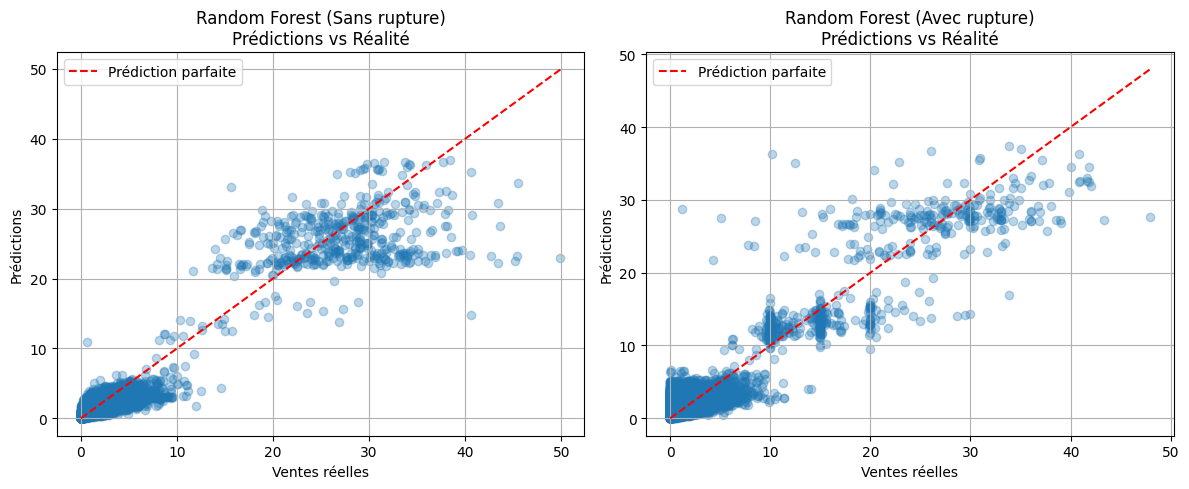

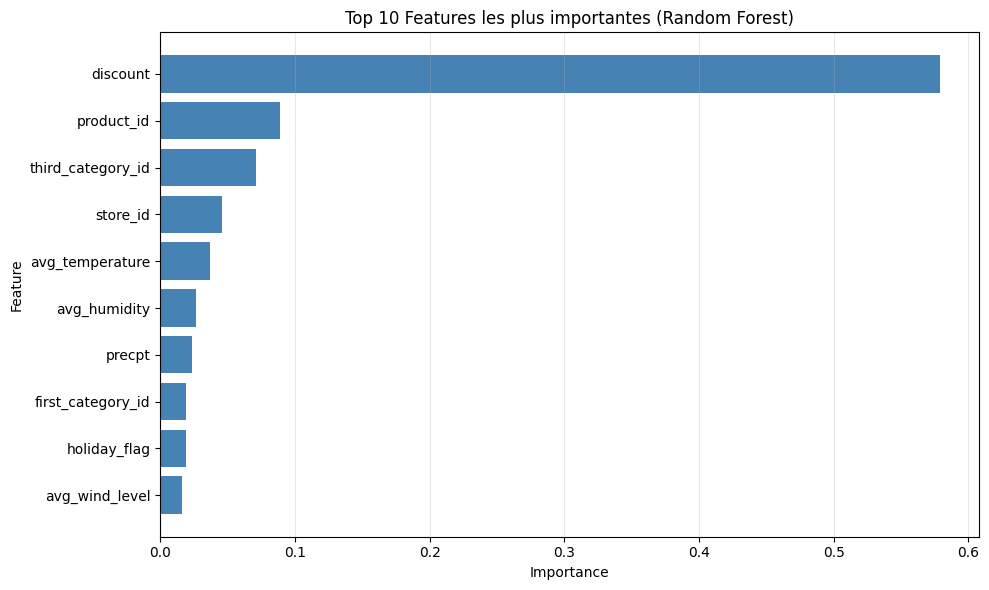

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. SÉPARATION SELON RUPTURE DE STOCK
# ============================================
train_no_stockout = train_df[
    train_df["hours_stock_status"].apply(lambda x: sum(x) == 0)
]

eval_no_stockout = eval_df[
    eval_df["hours_stock_status"].apply(lambda x: sum(x) == 0)]

eval_with_stockout = eval_df[
    eval_df["hours_stock_status"].apply(lambda x: sum(x) > 0)]

# CONVERSION EN PANDAS
df_train = train_no_stockout
df_eval_ok = eval_no_stockout
df_eval_oos = eval_with_stockout

# ============================================
# 2. FEATURE ENGINEERING
# ============================================
def feature_engineering(df):
    # Date
    df["dt"] = pd.to_datetime(df["dt"])
    df["day"] = df["dt"].dt.day
    df["month"] = df["dt"].dt.month
    df["day_of_week"] = df["dt"].dt.weekday
    df["weekend"] = (df["day_of_week"] >= 5).astype(int)

    return df

df_train = feature_engineering(df_train)
df_eval_ok = feature_engineering(df_eval_ok)
df_eval_oos = feature_engineering(df_eval_oos)

# ============================================
# 3. FEATURES & TARGET
# ============================================
features = [
    # Géographie & produit
    "city_id", "store_id", "management_group_id",
    "product_id",
    "first_category_id", "second_category_id", "third_category_id",

    # Business
    "discount", "holiday_flag", "activity_flag",

    # Stock
    "stock_hour6_22_cnt",

    # Météo
    "precpt", "avg_temperature", "avg_humidity", "avg_wind_level",

    # Temps
    "day", "month", "day_of_week", "weekend",
]

target = "sale_amount"

X_train = df_train[features]
y_train = df_train[target]

X_eval = df_eval_ok[features]
y_eval = df_eval_ok[target]

# ============================================
# 4. ENTRAÎNEMENT RANDOM FOREST
# ============================================
print("=== ENTRAÎNEMENT RANDOM FOREST ===")
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_leaf=2,
    min_samples_split=3,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)
print("Entraînement terminé !")

# ============================================
# 5. PRÉDICTIONS
# ============================================
y_pred = rf_model.predict(X_eval)

# ============================================
# 6. ÉVALUATION (SANS RUPTURE)
# ============================================
print("\n=== ÉVALUATION SANS RUPTURE ===")
mae = mean_absolute_error(y_eval, y_pred)
rmse = np.sqrt(mean_squared_error(y_eval, y_pred))
r2 = r2_score(y_eval, y_pred)
n = X_eval.shape[0]  # n = nombre d'observations
p = X_eval.shape[1]  # p = nombre de features utilisées
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE (no stockout)  : {mae:.4f}")
print(f"RMSE (no stockout) : {rmse:.4f}")
print(f"R² (coefficient de détermination) : {r2:.4f}")
print(f"R² ajusté : {r2_adj:.4f}")

# ============================================
# 7. ÉVALUATION OPTIONNELLE (AVEC RUPTURE)
# ============================================
y_pred_oos = None
if len(df_eval_oos) > 0:
    print("\n=== ÉVALUATION AVEC RUPTURE ===")
    X_eval_oos = df_eval_oos[features]
    y_eval_oos = df_eval_oos[target]

    y_pred_oos = rf_model.predict(X_eval_oos)

    mae_oos = mean_absolute_error(y_eval_oos, y_pred_oos)
    rmse_oos = np.sqrt(mean_squared_error(y_eval_oos, y_pred_oos))
    r2_oos = r2_score(y_eval_oos, y_pred_oos)
    n_oos = X_eval_oos.shape[0]
    p_oos = X_eval_oos.shape[1]
    r2_oos_adj = 1 - (1 - r2_oos) * (n_oos - 1) / (n_oos - p_oos - 1)

    print(f"MAE (with stockout)  : {mae_oos:.4f}")
    print(f"RMSE (with stockout) : {rmse_oos:.4f}")
    print(f"R² (coefficient de détermination) : {r2_oos:.4f}")
    print(f"R² ajusté : {r2_oos_adj:.4f}")

# ============================================
# 8. FEATURE IMPORTANCE
# ============================================
print("\n=== IMPORTANCE DES FEATURES ===")
importance = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

print("\nTop 10 features importantes :")
print(importance.head(10))

# ============================================================================
# 9. VISUALISATION DES PRÉDICTIONS
# ============================================================================

# Dictionnaire des modèles
models = {
    "Random Forest (Sans rupture)": {"y_true": y_eval, "y_pred": y_pred}
}

# Ajouter l'évaluation avec rupture si disponible
if y_pred_oos is not None and len(df_eval_oos) > 0:
    models["Random Forest (Avec rupture)"] = {"y_true": y_eval_oos, "y_pred": y_pred_oos}

# Nombre de modèles
n_models = len(models)

# Crée la figure avec 1 ligne et n colonnes
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

# Si un seul modèle, axes n'est pas une liste, donc on le transforme
if n_models == 1:
    axes = [axes]

# Boucle sur chaque modèle
for i, (model_name, data) in enumerate(models.items()):
    y_true = data["y_true"]
    y_pred_data = data["y_pred"]

    axes[i].scatter(y_true, y_pred_data, alpha=0.3)
    axes[i].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()], 'r--', label='Prédiction parfaite')
    axes[i].set_xlabel("Ventes réelles")
    axes[i].set_ylabel("Prédictions")
    axes[i].set_title(f"{model_name}\nPrédictions vs Réalité")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# 10. IMPORTANCE DES TOP 10 FEATURES
# ============================================================================

# Récupérer les 10 features les plus importantes
top_10_importance = importance.head(10)

# Créer le graphique d'importance
fig, ax = plt.subplots(figsize=(10, 6))

# Barplot horizontal pour mieux lire les noms de features
ax.barh(range(len(top_10_importance)), top_10_importance.values, color='steelblue')
ax.set_yticks(range(len(top_10_importance)))
ax.set_yticklabels(top_10_importance.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Top 10 Features les plus importantes (Random Forest)')
ax.grid(True, alpha=0.3, axis='x')

# Inverser l'axe y pour avoir la feature la plus importante en haut
ax.invert_yaxis()

plt.tight_layout()
plt.show()

**Modèle 4 : Réseau de neurones MLP**

=== ENTRAÎNEMENT DU MLP ===
Iteration 1, loss = 0.17805443
Iteration 2, loss = 0.12149992
Iteration 3, loss = 0.11350763
Iteration 4, loss = 0.10866856
Iteration 5, loss = 0.10493019
Iteration 6, loss = 0.10145315
Iteration 7, loss = 0.09970843
Iteration 8, loss = 0.09735447
Iteration 9, loss = 0.09625597
Iteration 10, loss = 0.09398553
Iteration 11, loss = 0.09279616
Iteration 12, loss = 0.09169383
Iteration 13, loss = 0.09017912
Iteration 14, loss = 0.08902696
Iteration 15, loss = 0.08792331
Iteration 16, loss = 0.08704355
Iteration 17, loss = 0.08629937
Iteration 18, loss = 0.08546624
Iteration 19, loss = 0.08475184

=== MÉTRIQUES D'ÉVALUATION ===
MSE sur eval : 0.6400
RMSE sur eval : 0.8000
MAE : 0.4209
R² : 0.9377
WAPE (%) : 31.43
WPE (%) : 2.12


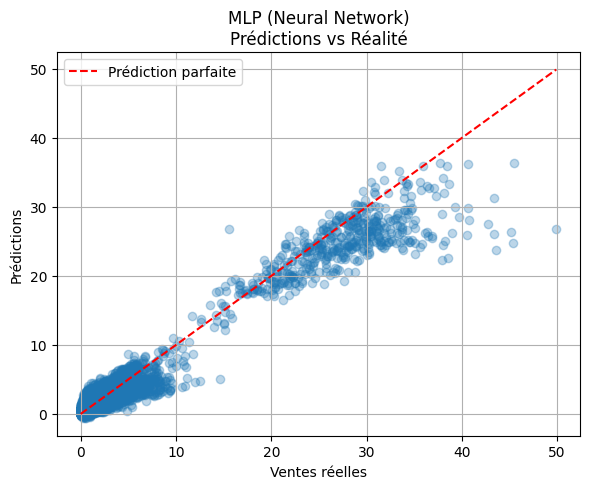

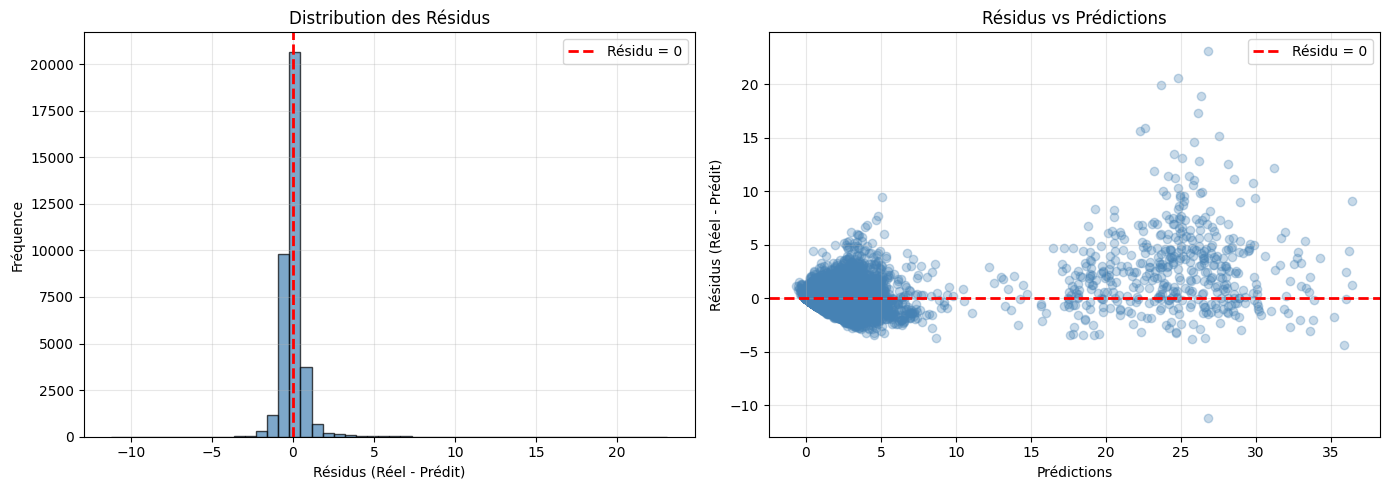


=== STATISTIQUES DES RÉSIDUS ===
Moyenne des résidus : 0.0284
Écart-type des résidus : 0.7995
Résidu min : -11.2018
Résidu max : 23.1165
Médiane des résidus : -0.0371


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. DÉFINIR LES FEATURES ET LA CIBLE
# ============================================
# Filter days without stockout
def filter_days_no_stockout(df):
    return df[df['hours_stock_status'].apply(lambda x: all(h == 0 for h in x))].copy()

train_clean = filter_days_no_stockout(train_df)
eval_clean = filter_days_no_stockout(eval_df)

cat_features = [
    "city_id", "store_id", "management_group_id",
    "first_category_id", "second_category_id", "third_category_id", "product_id"
]

num_features = [
    "discount", "holiday_flag", "activity_flag",
    "precpt", "avg_temperature", "avg_humidity", "avg_wind_level"
]

target = "sale_amount"  # ou "latent_demand" si tu l'as calculée

X = train_clean[cat_features + num_features]
y = train_clean['sale_amount']

# ============================================
# 2. CRÉER LE PRÉPROCESSEUR
# ============================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", StandardScaler(), num_features)
    ]
)

# ============================================
# 3. CRÉER LE PIPELINE MLP
# ============================================
print("=== ENTRAÎNEMENT DU MLP ===")
mlp_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        max_iter=300,
        random_state=42,
        verbose=True
    ))
])

mlp_model.fit(X, y)

# ============================================
# 4. PRÉDICTIONS
# ============================================
X_eval = eval_clean[cat_features + num_features]
y_eval = eval_clean['sale_amount']
y_eval_pred = mlp_model.predict(X_eval)

# ============================================
# 5. ÉVALUATION
# ============================================
print("\n=== MÉTRIQUES D'ÉVALUATION ===")
mse_eval = mean_squared_error(y_eval, y_eval_pred)
print(f"MSE sur eval : {mse_eval:.4f}")

rmse_eval = np.sqrt(mse_eval)
print(f"RMSE sur eval : {rmse_eval:.4f}")

mae = mean_absolute_error(y_eval, y_eval_pred)
print(f"MAE : {mae:.4f}")

r2 = r2_score(y_eval, y_eval_pred)
print(f"R² : {r2:.4f}")

# WAPE
wape = np.sum(np.abs(y_eval - y_eval_pred)) / np.sum(np.abs(y_eval)) * 100
print(f"WAPE (%) : {wape:.2f}")

# WPE / Bias
wpe = np.sum(y_eval - y_eval_pred) / np.sum(np.abs(y_eval)) * 100
print(f"WPE (%) : {wpe:.2f}")

# ============================================================================
# 6. VISUALISATION DES PRÉDICTIONS
# ============================================================================

# Dictionnaire des modèles
models = {
    "MLP (Neural Network)": {"y_true": y_eval, "y_pred": y_eval_pred}
}

# Nombre de modèles
n_models = len(models)

# Crée la figure avec 1 ligne et n colonnes
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

# Si un seul modèle, axes n'est pas une liste, donc on le transforme
if n_models == 1:
    axes = [axes]

# Boucle sur chaque modèle
for i, (model_name, data) in enumerate(models.items()):
    y_true = data["y_true"]
    y_pred_data = data["y_pred"]

    axes[i].scatter(y_true, y_pred_data, alpha=0.3)
    axes[i].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()], 'r--', label='Prédiction parfaite')
    axes[i].set_xlabel("Ventes réelles")
    axes[i].set_ylabel("Prédictions")
    axes[i].set_title(f"{model_name}\nPrédictions vs Réalité")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. ANALYSE DES RÉSIDUS
# ============================================================================

# Calculer les résidus
residuals = y_eval - y_eval_pred

# Créer une figure avec 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distribution des résidus
axes[0].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
axes[0].set_xlabel('Résidus (Réel - Prédit)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des Résidus')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2: Résidus vs Prédictions
axes[1].scatter(y_eval_pred, residuals, alpha=0.3, color='steelblue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
axes[1].set_xlabel('Prédictions')
axes[1].set_ylabel('Résidus (Réel - Prédit)')
axes[1].set_title('Résidus vs Prédictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 8. STATISTIQUES SUR LES RÉSIDUS
# ============================================================================
print("\n=== STATISTIQUES DES RÉSIDUS ===")
print(f"Moyenne des résidus : {residuals.mean():.4f}")
print(f"Écart-type des résidus : {residuals.std():.4f}")
print(f"Résidu min : {residuals.min():.4f}")
print(f"Résidu max : {residuals.max():.4f}")
print(f"Médiane des résidus : {residuals.median():.4f}")

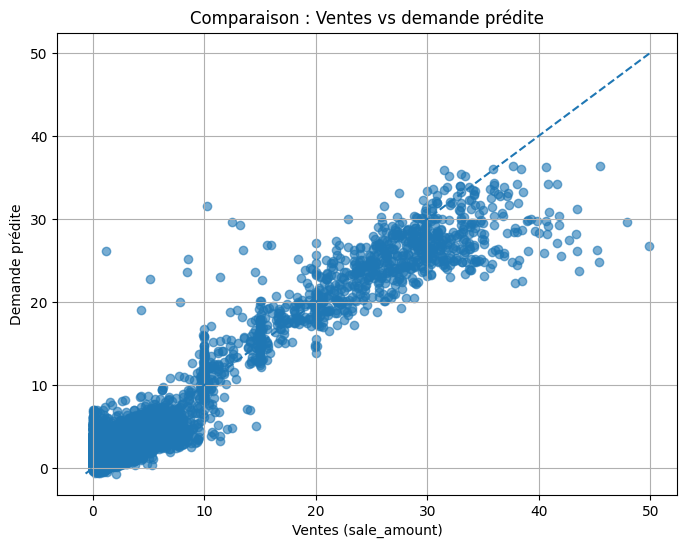

In [35]:
X_eval_df = eval_df[cat_features + num_features]
y_eval_df = eval_df[target]
y_eval_df_pred = mlp_model.predict(X_eval_df)

# calcul des bornes correctes
min_val = min(y_eval_df.min(), y_eval_df_pred.min())
max_val = max(y_eval_df.max(), y_eval_df_pred.max())

plt.figure(figsize=(8,6))
plt.scatter(y_eval_df, y_eval_df_pred, alpha=0.6)

# droite idéale y = x (corrigée)
plt.plot([min_val, max_val],
 [min_val, max_val],
 linestyle='--')

plt.xlabel("Ventes (sale_amount)")
plt.ylabel("Demande prédite")
plt.title("Comparaison : Ventes vs demande prédite")
plt.grid(True)
plt.show()

**Prédiction des signaux de rupture de stock**

Cette étape consiste à analyser les signaux précurseurs des ruptures de stock en s’appuyant sur l’historique des ventes et du stock sur une fenêtre d’une semaine.
Deux modèles de machine learning sont utilisés pour cette tâche :

1.   Gradient Boosting
2.   LightGBM

L’objectif est d’identifier le plus efficacement possible les situations à risque afin d’anticiper les ruptures de stock.


**Modèle 1** : Gradient Boosting

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

# PRÉPARATION DES DONNÉES
print("CHARGEMENT ET OPTIMISATION DES DONNÉES")

train_df = train_df.sort_values(["store_id", "product_id", "dt"]).reset_index(drop=True)
eval_df  = eval_df.sort_values(["store_id", "product_id", "dt"]).reset_index(drop=True)

# Optimisation des types de données
id_cols = ["city_id","store_id","management_group_id",
           "first_category_id","second_category_id","third_category_id","product_id"]
for c in id_cols:
    train_df[c] = train_df[c].astype("int32")
    eval_df[c]  = eval_df[c].astype("int32")

for c in ["holiday_flag","activity_flag","stock_hour6_22_cnt"]:
    train_df[c] = train_df[c].astype("int16")
    eval_df[c]  = eval_df[c].astype("int16")

print(f"Train: {len(train_df):,} lignes")
print(f"Eval:  {len(eval_df):,} lignes")

# CRÉATION DES LABELS
print("CRÉATION DES LABELS (is_stockout + pre_stockout)")
def add_labels_fast(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["is_stockout"] = (df["stock_hour6_22_cnt"] > 0).astype("int8")

    g = df.groupby(["store_id","product_id"], sort=False)
    df["is_stockout_next"] = g["is_stockout"].shift(-1).fillna(0).astype("int8")

    df["pre_stockout"] = ((df["is_stockout"] == 0) & (df["is_stockout_next"] == 1)).astype("int8")
    return df

train_df = add_labels_fast(train_df)
eval_df  = add_labels_fast(eval_df)

print("\n Distribution des labels (Train):")
label_dist = train_df[["pre_stockout","is_stockout"]].value_counts().sort_index()
for idx, count in label_dist.items():
    pre, stock = idx
    label = f"pre_stockout={pre}, is_stockout={stock}"
    pct = 100 * count / len(train_df)
    print(f"   {label:35s} → {count:8,} ({pct:5.2f}%)")

# FEATURE ENGINEERING JOURNALIER

print("FEATURE ENGINEERING (stats journalières)")
def compute_day_features(df: pd.DataFrame) -> pd.DataFrame:
    hs_list = df["hours_sale"].to_list()
    st_list = df["hours_stock_status"].to_list()
    n = len(df)

    sale_mean = np.zeros(n, dtype=np.float32)
    sale_std  = np.zeros(n, dtype=np.float32)
    sale_max  = np.zeros(n, dtype=np.float32)
    stockout_hours = np.zeros(n, dtype=np.int16)
    first_stockout_hour = np.full(n, 24, dtype=np.int16)

    for i, (hs, st) in enumerate(zip(hs_list, st_list)):
        hs = np.asarray(hs, dtype=np.float32)
        st = np.asarray(st, dtype=np.int8)
        stockout_hours[i] = int(st.sum())

        if stockout_hours[i] > 0:
            first_stockout_hour[i] = int(np.argmax(st == 1))

        mask = (st == 0)
        if mask.any():
            obs = hs[mask]
            sale_mean[i] = obs.mean()
            sale_std[i]  = obs.std()
            sale_max[i]  = obs.max()

    out = df.copy()
    out["sale_mean_obs"] = sale_mean
    out["sale_std_obs"]  = sale_std
    out["sale_max_obs"]  = sale_max
    out["stockout_hours"] = stockout_hours
    out["recent_stockout"] = (out["stockout_hours"] > 0).astype("int8")
    out["first_stockout_hour"] = first_stockout_hour
    return out

train_df = compute_day_features(train_df)
eval_df  = compute_day_features(eval_df)

print("Features journalières créées: sale_mean_obs, sale_std_obs, sale_max_obs")
print("Features stockout créées: stockout_hours, recent_stockout, first_stockout_hour")

# FEATURES ROLLING (7 JOURS)
print("FEATURES ROLLING (fenêtre 7 jours)")
WINDOW = 7
context_cols = ["discount","holiday_flag","activity_flag","precpt",
                "avg_temperature","avg_humidity","avg_wind_level"]

def add_rolling(df: pd.DataFrame, window=7) -> pd.DataFrame:
    df = df.copy()
    g = df.groupby(["store_id","product_id"], sort=False)

    df["sale_mean_7d"] = g["sale_mean_obs"].transform(lambda s: s.rolling(window).mean())
    df["sale_std_7d"]  = g["sale_std_obs"].transform(lambda s: s.rolling(window).mean())
    df["sale_max_7d"]  = g["sale_max_obs"].transform(lambda s: s.rolling(window).max())

    df["stockout_hours_7d"] = g["stockout_hours"].transform(lambda s: s.rolling(window).sum())
    df["first_stockout_hour_7d_min"] = g["first_stockout_hour"].transform(lambda s: s.rolling(window).min())

    df["sale_trend_1d"] = g["sale_mean_7d"].diff(1)

    for c in context_cols:
        df[f"{c}_mean_{window}d"] = g[c].transform(lambda s: s.rolling(window).mean())

    return df

train_df = add_rolling(train_df, window=WINDOW)
eval_df  = add_rolling(eval_df,  window=WINDOW)

print(f"Features rolling créées avec fenêtre de {WINDOW} jours")
print(f"{len(context_cols)} variables contextuelles moyennées sur {WINDOW}j")

#CONSTRUCTION DES DATASETS X, y
print("CONSTRUCTION DES DATASETS (sans fuite)")

FEATURES = [
    "sale_mean_7d","sale_std_7d","sale_max_7d","sale_trend_1d",
    "stockout_hours_7d","recent_stockout","first_stockout_hour_7d_min",
] + [f"{c}_mean_{WINDOW}d" for c in context_cols]

def build_xy(df: pd.DataFrame):
    df2 = df[df["is_stockout"] == 0].copy()
    df2 = df2.dropna(subset=FEATURES + ["pre_stockout"])
    X = df2[FEATURES]
    y = df2["pre_stockout"].astype(int)
    return X, y, df2

X_train, y_train, train_ready = build_xy(train_df)
X_eval,  y_eval,  eval_ready  = build_xy(eval_df)

print(f"\n TRAIN SET:")
print(f"   Shape:     {X_train.shape[0]:,} lignes × {X_train.shape[1]} features")
print(f"   Positifs:  {y_train.sum():,} ({100*y_train.mean():.3f}%)")

print(f"\n EVAL SET:")
print(f"   Shape:     {X_eval.shape[0]:,} lignes × {X_eval.shape[1]} features")
print(f"   Positifs:  {y_eval.sum():,} ({100*y_eval.mean():.3f}%)")

# ANALYSE DESCRIPTIVE
print("ANALYSE: Différences moyennes entre pré-rupture (1) vs normal (0)")
means = train_ready.groupby("pre_stockout")[FEATURES].mean()
delta = (means.loc[1] - means.loc[0]).sort_values(ascending=False)

print("\n Top 15 features discriminantes (pré-rupture - normal):")
for i, (feat, val) in enumerate(delta.head(15).items(), 1):
    print(f"   {i:2d}. {feat:35s} → {val:+10.4f}")

# ENTRAÎNEMENT MODÈLE (FULL TRAIN)
print("ENTRAÎNEMENT DU MODÈLE (HistGradientBoosting)")

clf = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.1,
    max_iter=300,
    random_state=42
)
clf.fit(X_train, y_train)

print("Modèle entraîné avec succès")

# Prédictions sur TRAIN
proba_train = clf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, proba_train)
prauc_train = average_precision_score(y_train, proba_train)

print(f"\n PERFORMANCES SUR TRAIN:")
print(f"   ROC-AUC:  {auc_train:.4f}")
print(f"   PR-AUC:   {prauc_train:.4f}")

def recall_at_k(y_true, scores, k):
    k = min(k, len(scores))
    topk = np.argsort(scores)[-k:]
    return y_true.iloc[topk].sum() / max(1, y_true.sum())

print(f"\n   Recall@K:")
for k in [1000, 5000, 10000]:
    rec = recall_at_k(y_train, proba_train, k)
    print(f"      @{k:5,}: {rec:.4f}")

# VALIDATION TEMPORELLE (85/15 SPLIT)
print("VALIDATION TEMPORELLE (split 85/15)")
train_ready = train_ready.copy()
train_ready["dt"] = pd.to_datetime(train_ready["dt"])
train_ready = train_ready.sort_values("dt").reset_index(drop=True)

print(f"\n Période couverte:")
print(f"   Min: {train_ready['dt'].min().strftime('%Y-%m-%d')}")
print(f"   Max: {train_ready['dt'].max().strftime('%Y-%m-%d')}")

# Cherche un split avec au moins 100 positifs en validation
for frac in [0.7, 0.75, 0.8, 0.85, 0.9]:
    cut = int(len(train_ready) * frac)
    val_tmp = train_ready.iloc[cut:]
    if val_tmp["pre_stockout"].sum() >= 100:
        cut_idx = cut
        break

train_part = train_ready.iloc[:cut_idx].copy()
val_part   = train_ready.iloc[cut_idx:].copy()

X_tr = train_part[FEATURES]
y_tr = train_part["pre_stockout"].astype(int)
X_va = val_part[FEATURES]
y_va = val_part["pre_stockout"].astype(int)

print(f"\n SPLIT CHOISI: {100*cut_idx/len(train_ready):.1f}% / {100*(1-cut_idx/len(train_ready)):.1f}%")
print(f"\n TRAIN PART:")
print(f"      Shape:     {X_tr.shape[0]:,} lignes")
print(f"      Positifs:  {y_tr.sum():,} ({100*y_tr.mean():.3f}%)")
print(f"      Période:   {train_part['dt'].min().strftime('%Y-%m-%d')} → {train_part['dt'].max().strftime('%Y-%m-%d')}")

print(f"\n AL PART:")
print(f"      Shape:     {X_va.shape[0]:,} lignes")
print(f"      Positifs:  {y_va.sum():,} ({100*y_va.mean():.3f}%)")
print(f"      Période:   {val_part['dt'].min().strftime('%Y-%m-%d')} → {val_part['dt'].max().strftime('%Y-%m-%d')}")

# Entraînement sur train_part
clf_val = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.1,
    max_iter=300,
    random_state=42
)
clf_val.fit(X_tr, y_tr)

proba_val = clf_val.predict_proba(X_va)[:, 1]
auc_val = roc_auc_score(y_va, proba_val)
prauc_val = average_precision_score(y_va, proba_val)

print(f"\nPERFORMANCES SUR VALIDATION:")
print(f"   ROC-AUC:  {auc_val:.4f}")
print(f"   PR-AUC:   {prauc_val:.4f}")

print(f"\n   Recall@K:")
for k in [1000, 5000, 10000]:
    rec = recall_at_k(y_va, proba_val, k)
    print(f"      @{k:5,}: {rec:.4f}")

#  MÉTRIQUES PRECISION / RECALL / F1 (seuil top 1%)
print("PRECISION / RECALL / F1-SCORE (seuil top 1%)")

threshold = np.quantile(proba_val, 0.99)
pred = (proba_val >= threshold).astype(int)

print(f"\n Seuil utilisé (top 1%): {threshold:.6f}")
print(f"Alertes générées:        {pred.sum():,} / {len(pred):,} ({100*pred.sum()/len(pred):.2f}%)")

precision = precision_score(y_va, pred, zero_division=0)
recall = recall_score(y_va, pred, zero_division=0)
f1 = f1_score(y_va, pred, zero_division=0)

print(f"\n MÉTRIQUES:")
print(f"   Precision:  {precision:.4f}")
print(f"   Recall:     {recall:.4f}")
print(f"   F1-Score:   {f1:.4f}")

print(f"\n MATRICE DE CONFUSION:")
cm = confusion_matrix(y_va, pred)
print(f"\n                 Prédit: Négatif   Prédit: Positif")
print(f"   Réel: Négatif     {cm[0,0]:8,}         {cm[0,1]:8,}")
print(f"   Réel: Positif     {cm[1,0]:8,}         {cm[1,1]:8,}")

print(f"\n   Détails:")
print(f"      True Negatives  (TN): {cm[0,0]:8,}")
print(f"      False Positives (FP): {cm[0,1]:8,}")
print(f"      False Negatives (FN): {cm[1,0]:8,}")
print(f"      True Positives  (TP): {cm[1,1]:8,}")

print(f"\n RAPPORT DE CLASSIFICATION DÉTAILLÉ:")
print(classification_report(y_va, pred, digits=4,
                          target_names=['Normal (0)', 'Pré-rupture (1)']))

#RÉSUMÉ FINAL
print("RÉSUMÉ FINAL")

print(f"\n DONNÉES:")
print(f"   Train original:      {len(train_df):,} lignes")
print(f"   Train utilisable:    {len(train_ready):,} lignes")
print(f"   Eval utilisable:     {len(eval_ready):,} lignes")
print(f"   Features:            {len(FEATURES)} variables")

print(f"\n PERFORMANCES VALIDATION:")
print(f"   ROC-AUC:    {auc_val:.4f}")
print(f"   PR-AUC:     {prauc_val:.4f}")
print(f"   Precision:  {precision:.4f}")
print(f"   Recall:     {recall:.4f}")
print(f"   F1-Score:   {f1:.4f}")

print(f"\n ALERTES (top 1%):")
print(f"   Générées:   {pred.sum():,}")
print(f"   Vraies:     {cm[1,1]:,}")
print(f"   Fausses:    {cm[0,1]:,}")
print(f"   Taux hit:   {100*cm[1,1]/max(1,pred.sum()):.2f}%")

CHARGEMENT ET OPTIMISATION DES DONNÉES
Train: 1,070,640 lignes
Eval:  350,000 lignes
CRÉATION DES LABELS (is_stockout + pre_stockout)

 Distribution des labels (Train):
   pre_stockout=0, is_stockout=0       →  413,903 (38.66%)
   pre_stockout=0, is_stockout=1       →  483,558 (45.17%)
   pre_stockout=1, is_stockout=0       →  173,179 (16.18%)
FEATURE ENGINEERING (stats journalières)
Features journalières créées: sale_mean_obs, sale_std_obs, sale_max_obs
Features stockout créées: stockout_hours, recent_stockout, first_stockout_hour
FEATURES ROLLING (fenêtre 7 jours)
Features rolling créées avec fenêtre de 7 jours
7 variables contextuelles moyennées sur 7j
CONSTRUCTION DES DATASETS (sans fuite)

 TRAIN SET:
   Shape:     541,220 lignes × 14 features
   Positifs:  159,900 (29.544%)

 EVAL SET:
   Shape:     0 lignes × 14 features
   Positifs:  0 (nan%)
ANALYSE: Différences moyennes entre pré-rupture (1) vs normal (0)

 Top 15 features discriminantes (pré-rupture - normal):
    1. stockou

**Modèle 2 : LightGBM**

In [ ]:
import lightgbm as lgb
import numpy as np

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

# PREPARATION DES DONNEES
print("PREPARATION DES DONNEES")
print("\nTRAIN SET:")
print(f"  Shape:              {X_tr.shape[0]:,} lignes x {X_tr.shape[1]} features")
print(f"  Positifs:           {y_tr.sum():,} ({100*y_tr.mean():.3f}%)")
print(f"  Negatifs:           {(len(y_tr) - y_tr.sum()):,} ({100*(1-y_tr.mean()):.3f}%)")

print("\nVALIDATION SET:")
print(f"  Shape:              {X_va.shape[0]:,} lignes x {X_va.shape[1]} features")
print(f"  Positifs:           {y_va.sum():,} ({100*y_va.mean():.3f}%)")
print(f"  Negatifs:           {(len(y_va) - y_va.sum()):,} ({100*(1-y_va.mean()):.3f}%)")

# Calcul du poids pour équilibrer les classes
pos = y_tr.sum()
neg = len(y_tr) - pos
scale_pos_weight = neg / pos

print("\nEQUILIBRAGE DES CLASSES:")
print(f"  Ratio Neg/Pos:      {scale_pos_weight:.2f}")
print(f"  scale_pos_weight:   {scale_pos_weight:.2f}")

print("ENTRAINEMENT DU MODELE LIGHTGBM")
print(f"  scale_pos_weight:   {scale_pos_weight:.2f}")

lgbm = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_samples=50,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

print("\nEntrainement en cours...")
lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="auc"
)

print("\nModele entraine avec succes")

# PREDICTIONS ET EVALUATION
print("EVALUATION DES PERFORMANCES")

proba = lgbm.predict_proba(X_va)[:, 1]

auc = roc_auc_score(y_va, proba)
prauc = average_precision_score(y_va, proba)

print("\nMETRIQUES GLOBALES:")
print(f"  ROC-AUC:            {auc:.4f}")
print(f"  PR-AUC:             {prauc:.4f}")

# Fonction Recall@K
def recall_at_k(y_true, scores, k):
    k = min(k, len(scores))
    topk = np.argsort(scores)[-k:]
    return y_true.iloc[topk].sum() / max(1, y_true.sum())

print("\nRECALL @ K (top K predictions):")
for k in [1000, 5000, 10000]:
    rec = recall_at_k(y_va, proba, k)
    captured = int(rec * y_va.sum())
    print(f"  Recall@{k:5,}:       {rec:.4f}  ({captured:4,} / {y_va.sum():,} positifs captures)")

# SEUIL OPERATIONNEL (K = 5000)
print("SEUIL OPERATIONNEL (capacite K = 5000)")

K = 5000  # capacité opérationnelle
threshold = np.partition(proba, -K)[-K]

pred = (proba >= threshold).astype(int)

print(f"\nPARAMETRES:")
print(f"  Capacite K:         {K:,} alertes max")
print(f"  Seuil calcule:      {threshold:.6f}")
print(f"  Alertes generees:   {pred.sum():,}")

# Metriques avec ce seuil
precision = precision_score(y_va, pred, zero_division=0)
recall = recall_score(y_va, pred, zero_division=0)
f1 = f1_score(y_va, pred, zero_division=0)

print(f"\nMETRIQUES AVEC SEUIL K={K:,}:")
print(f"  Precision:          {precision:.4f}")
print(f"  Recall:             {recall:.4f}")
print(f"  F1-Score:           {f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_va, pred)

print(f"\nMATRICE DE CONFUSION:")
print(f"\n                      Predit: Negatif   Predit: Positif")
print(f"  Reel: Negatif           {cm[0,0]:10,}         {cm[0,1]:10,}")
print(f"  Reel: Positif           {cm[1,0]:10,}         {cm[1,1]:10,}")

print(f"\nDETAILS:")
print(f"  True Negatives  (TN):   {cm[0,0]:10,}  (corrects negatifs)")
print(f"  False Positives (FP):   {cm[0,1]:10,}  (fausses alertes)")
print(f"  False Negatives (FN):   {cm[1,0]:10,}  (ruptures manquees)")
print(f"  True Positives  (TP):   {cm[1,1]:10,}  (ruptures detectees)")

# Taux de précision opérationnelle
if pred.sum() > 0:
    hit_rate = 100 * cm[1,1] / pred.sum()
    print(f"\nTAUX DE REUSSITE:")
    print(f"  Alertes utiles:     {cm[1,1]:,} / {pred.sum():,} ({hit_rate:.2f}%)")

# Rapport de classification détaillé
print("RAPPORT DE CLASSIFICATION DETAILLE")
print()
print(classification_report(y_va, pred, digits=4,
                          target_names=['Classe 0: Normal', 'Classe 1: Pre-rupture']))

# RESUME FINAL
print("RESUME FINAL")
print("\nDONNEES:")
print(f"  Train:              {X_tr.shape[0]:,} lignes")
print(f"  Validation:         {X_va.shape[0]:,} lignes")
print(f"  Features:           {X_tr.shape[1]} variables")

print("\nPERFORMANCES VALIDATION:")
print(f"  ROC-AUC:            {auc:.4f}")
print(f"  PR-AUC:             {prauc:.4f}")
print(f"  Precision (K={K:,}):  {precision:.4f}")
print(f"  Recall (K={K:,}):     {recall:.4f}")
print(f"  F1-Score (K={K:,}):   {f1:.4f}")

print("\nALERTES OPERATIONNELLES:")
print(f"  Capacite:           {K:,} alertes max")
print(f"  Generees:           {pred.sum():,}")
print(f"  Vraies:             {cm[1,1]:,}")
print(f"  Fausses:            {cm[0,1]:,}")
if pred.sum() > 0:
    print(f"  Taux de reussite:   {100*cm[1,1]/pred.sum():.2f}%")


PREPARATION DES DONNEES

TRAIN SET:
  Shape:              378,854 lignes x 14 features
  Positifs:           115,682 (30.535%)
  Negatifs:           263,172 (69.465%)

VALIDATION SET:
  Shape:              162,366 lignes x 14 features
  Positifs:           44,218 (27.234%)
  Negatifs:           118,148 (72.766%)

EQUILIBRAGE DES CLASSES:
  Ratio Neg/Pos:      2.27
  scale_pos_weight:   2.27
ENTRAINEMENT DU MODELE LIGHTGBM
  scale_pos_weight:   2.27

Entrainement en cours...
[LightGBM] [Info] Number of positive: 115682, number of negative: 263172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 378854, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.305347 -> initscore=-0.821963
[LightGBM] [In

“A more expressive tree-based model (LightGBM) did not outperform a simpler gradient boosting baseline, suggesting that model capacity is not the main bottleneck. Instead, feature expressiveness plays a critical role in early stockout signal detection.”


**Ajout des features qui font vraiment la différence**

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import lightgbm as lgb

# CREATION DES FEATURES ROLLING (court et long terme)
SHORT = 3
LONG  = 7

print(f"\nFENETRES TEMPORELLES:")
print(f"  Court terme:        {SHORT} jours")
print(f"  Long terme:         {LONG} jours")

def add_short_long_rolling(df):
    df = df.copy()
    g = df.groupby(["store_id","product_id"], sort=False)

    df["sale_mean_3d"] = g["sale_mean_obs"].transform(lambda s: s.rolling(SHORT).mean())
    df["sale_std_3d"]  = g["sale_std_obs"].transform(lambda s: s.rolling(SHORT).mean())
    df["sale_max_3d"]  = g["sale_max_obs"].transform(lambda s: s.rolling(SHORT).max())

    df["sale_mean_7d"] = g["sale_mean_obs"].transform(lambda s: s.rolling(LONG).mean())
    df["sale_std_7d"]  = g["sale_std_obs"].transform(lambda s: s.rolling(LONG).mean())
    df["sale_max_7d"]  = g["sale_max_obs"].transform(lambda s: s.rolling(LONG).max())

    return df

train_df = add_short_long_rolling(train_df)
eval_df  = add_short_long_rolling(eval_df)

print("\nFeatures rolling creees:")
print(f"  - sale_mean_3d, sale_std_3d, sale_max_3d")
print(f"  - sale_mean_7d, sale_std_7d, sale_max_7d")

# CREATION DES 5 FEATURES AVANCEES
print("CREATION DES 5 FEATURES AVANCEES")

def add_power_features(df):
    df = df.copy()

    # 1. Acceleration de la demande
    df["demand_acceleration"] = df["sale_mean_3d"] - df["sale_mean_7d"]

    # 2. Volatilite relative
    df["volatility_ratio"] = df["sale_std_3d"] / (df["sale_std_7d"] + 1e-6)

    # 3. Choc de demande
    df["delta_max"] = df["sale_max_3d"] - df["sale_max_7d"]

    # 4. Pression de la demande
    df["demand_pressure"] = df["sale_mean_3d"] * df["stockout_hours_7d"]

    # 5. Signal de demande precoce
    df["early_demand_signal"] = df["sale_max_3d"] / (df["sale_mean_3d"] + 1e-6)

    return df

train_df = add_power_features(train_df)
eval_df  = add_power_features(eval_df)

print("\nNOUVELLES FEATURES CREEES:")
print("  1. demand_acceleration      (sale_mean_3d - sale_mean_7d)")
print("  2. volatility_ratio         (sale_std_3d / sale_std_7d)")
print("  3. delta_max                (sale_max_3d - sale_max_7d)")
print("  4. demand_pressure          (sale_mean_3d * stockout_hours_7d)")
print("  5. early_demand_signal      (sale_max_3d / sale_mean_3d)")

# CONSTRUCTION DES DATASETS ETENDUS
print("CONSTRUCTION DES DATASETS ETENDUS")

NEW_FEATURES = [
    "demand_acceleration",
    "volatility_ratio",
    "delta_max",
    "demand_pressure",
    "early_demand_signal",
]

FEATURES_EXTENDED = FEATURES + NEW_FEATURES
print(f"\nNOMBRE DE FEATURES:")
print(f"  Features originales:    {len(FEATURES)}")
print(f"  Nouvelles features:     {len(NEW_FEATURES)}")
print(f"  Total features:         {len(FEATURES_EXTENDED)}")

def build_xy_extended(df):
    df2 = df[df["is_stockout"] == 0].copy()
    df2 = df2.dropna(subset=FEATURES_EXTENDED + ["pre_stockout"])
    X = df2[FEATURES_EXTENDED]
    y = df2["pre_stockout"].astype(int)
    return X, y, df2

X_tr_init, y_tr_init, train_ready_ext = build_xy_extended(train_df)
X_va_init, y_va_init, val_ready_ext   = build_xy_extended(eval_df)

print("\nDATASETS INITIAUX (avant split temporel):")
print(f"  Train:              {X_tr_init.shape[0]:,} lignes x {X_tr_init.shape[1]} features")
print(f"  Eval:               {X_va_init.shape[0]:,} lignes x {X_va_init.shape[1]} features")
print(f"  Eval positifs:      {y_va_init.sum():,} ({100*y_va_init.mean():.3f}%)")

# SPLIT TEMPOREL (85/15)
print("SPLIT TEMPOREL POUR VALIDATION")

train_ready_ext = train_ready_ext.copy()
train_ready_ext["dt"] = pd.to_datetime(train_ready_ext["dt"])
train_ready_ext = train_ready_ext.sort_values("dt").reset_index(drop=True)

print(f"\nPERIODE COUVERTE:")
print(f"  Date min:           {train_ready_ext['dt'].min().strftime('%Y-%m-%d')}")
print(f"  Date max:           {train_ready_ext['dt'].max().strftime('%Y-%m-%d')}")

cut_idx = int(len(train_ready_ext) * 0.85)

train_part = train_ready_ext.iloc[:cut_idx]
val_part   = train_ready_ext.iloc[cut_idx:]

X_tr = train_part[FEATURES_EXTENDED]
y_tr = train_part["pre_stockout"].astype(int)

X_va = val_part[FEATURES_EXTENDED]
y_va = val_part["pre_stockout"].astype(int)

print(f"\nSPLIT CHOISI: 85% / 15%")

print(f"\nTRAIN PART:")
print(f"  Shape:              {X_tr.shape[0]:,} lignes x {X_tr.shape[1]} features")
print(f"  Positifs:           {y_tr.sum():,} ({100*y_tr.mean():.3f}%)")
print(f"  Periode:            {train_part['dt'].min().strftime('%Y-%m-%d')} -> {train_part['dt'].max().strftime('%Y-%m-%d')}")

print(f"\nVALIDATION PART:")
print(f"  Shape:              {X_va.shape[0]:,} lignes x {X_va.shape[1]} features")
print(f"  Positifs:           {y_va.sum():,} ({100*y_va.mean():.3f}%)")
print(f"  Periode:            {val_part['dt'].min().strftime('%Y-%m-%d')} -> {val_part['dt'].max().strftime('%Y-%m-%d')}")

# CALCUL DU POIDS DES CLASSES
print("EQUILIBRAGE DES CLASSES")

pos = y_tr.sum()
neg = len(y_tr) - pos
scale_pos_weight = neg / pos

print(f"\nDISTRIBUTION DES CLASSES (Train):")
print(f"  Classe 0 (negatif): {neg:,} ({100*neg/len(y_tr):.2f}%)")
print(f"  Classe 1 (positif): {pos:,} ({100*pos/len(y_tr):.2f}%)")
print(f"\nPOIDS CALCULE:")
print(f"  scale_pos_weight:   {scale_pos_weight:.4f}")

# ENTRAINEMENT DU MODELE LIGHTGBM
print("ENTRAINEMENT DU MODELE LIGHTGBM")
print(f"  scale_pos_weight:   {scale_pos_weight:.4f}")

lgbm = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=48,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=80,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

print("\nEntrainement en cours...")
lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="auc"
)

print("\nModele entraine avec succes")

# EVALUATION DES PERFORMANCES
print("\n" + "="*80)
print("ETAPE 7: EVALUATION DES PERFORMANCES")
print("="*80)

proba = lgbm.predict_proba(X_va)[:, 1]

auc = roc_auc_score(y_va, proba)
prauc = average_precision_score(y_va, proba)

print("\nMETRIQUES GLOBALES:")
print(f"  ROC-AUC:            {auc:.4f}")
print(f"  PR-AUC:             {prauc:.4f}")

def recall_at_k(y_true, scores, k):
    k = min(k, len(scores))
    topk = np.argsort(scores)[-k:]
    return y_true.iloc[topk].sum() / max(1, y_true.sum())

print("\nRECALL @ K (top K predictions):")
for k in [1000, 5000, 10000]:
    rec = recall_at_k(y_va, proba, k)
    captured = int(rec * y_va.sum())
    print(f"  Recall@{k:5,}:       {rec:.4f}  ({captured:4,} / {y_va.sum():,} positifs captures)")

# ANALYSE DES FEATURES
print("IMPORTANCE DES FEATURES")

feature_importance = pd.DataFrame({
    'feature': FEATURES_EXTENDED,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 15 FEATURES LES PLUS IMPORTANTES:")
for i, row in enumerate(feature_importance.head(15).itertuples(), 1):
    is_new = "(NOUVELLE)" if row.feature in NEW_FEATURES else ""
    print(f"  {i:2d}. {row.feature:35s} {row.importance:10.1f}  {is_new}")

print("\nIMPORTANCE DES NOUVELLES FEATURES:")
new_feat_importance = feature_importance[feature_importance['feature'].isin(NEW_FEATURES)]
for i, row in enumerate(new_feat_importance.itertuples(), 1):
    rank = feature_importance.index.get_loc(row.Index) + 1
    print(f"  {row.feature:30s} Rank: {rank:3d}  Importance: {row.importance:10.1f}")

# RESUME FINAL
print("RESUME FINAL")
print("\nDONNEES:")
print(f"  Train:              {X_tr.shape[0]:,} lignes")
print(f"  Validation:         {X_va.shape[0]:,} lignes")
print(f"  Features totales:   {len(FEATURES_EXTENDED)} ({len(FEATURES)} originales + {len(NEW_FEATURES)} nouvelles)")

print("\nPERFORMANCES VALIDATION:")
print(f"  ROC-AUC:            {auc:.4f}")
print(f"  PR-AUC:             {prauc:.4f}")

print("\nNOUVELLES FEATURES:")
for feat in NEW_FEATURES:
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    rank = feature_importance[feature_importance['feature'] == feat].index[0] + 1
    print(f"  {feat:30s} Rank: {rank:3d}  Importance: {imp:10.1f}")


FENETRES TEMPORELLES:
  Court terme:        3 jours
  Long terme:         7 jours

Features rolling creees:
  - sale_mean_3d, sale_std_3d, sale_max_3d
  - sale_mean_7d, sale_std_7d, sale_max_7d
CREATION DES 5 FEATURES AVANCEES

NOUVELLES FEATURES CREEES:
  1. demand_acceleration      (sale_mean_3d - sale_mean_7d)
  2. volatility_ratio         (sale_std_3d / sale_std_7d)
  3. delta_max                (sale_max_3d - sale_max_7d)
  4. demand_pressure          (sale_mean_3d * stockout_hours_7d)
  5. early_demand_signal      (sale_max_3d / sale_mean_3d)
CONSTRUCTION DES DATASETS ETENDUS

NOMBRE DE FEATURES:
  Features originales:    14
  Nouvelles features:     5
  Total features:         19

DATASETS INITIAUX (avant split temporel):
  Train:              541,220 lignes x 19 features
  Eval:               0 lignes x 19 features
  Eval positifs:      0 (nan%)
SPLIT TEMPOREL POUR VALIDATION

PERIODE COUVERTE:
  Date min:           2024-04-04
  Date max:           2024-06-25

SPLIT CHOISI: 85

Shap

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


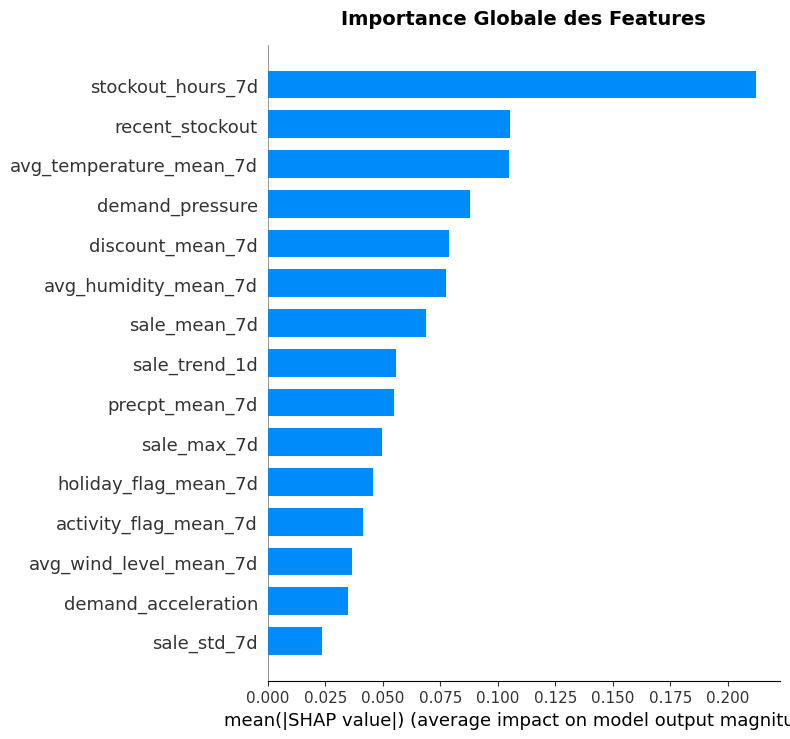

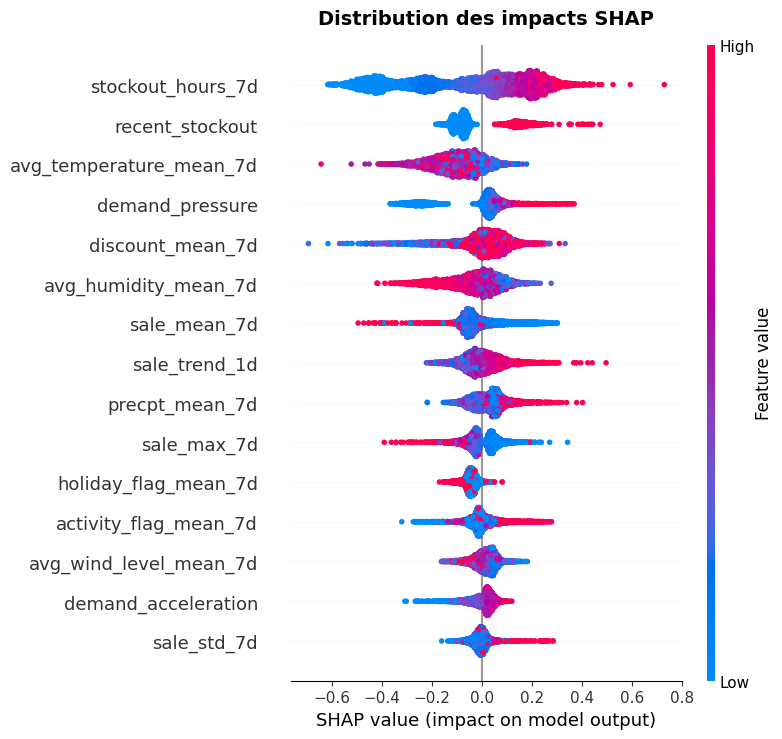

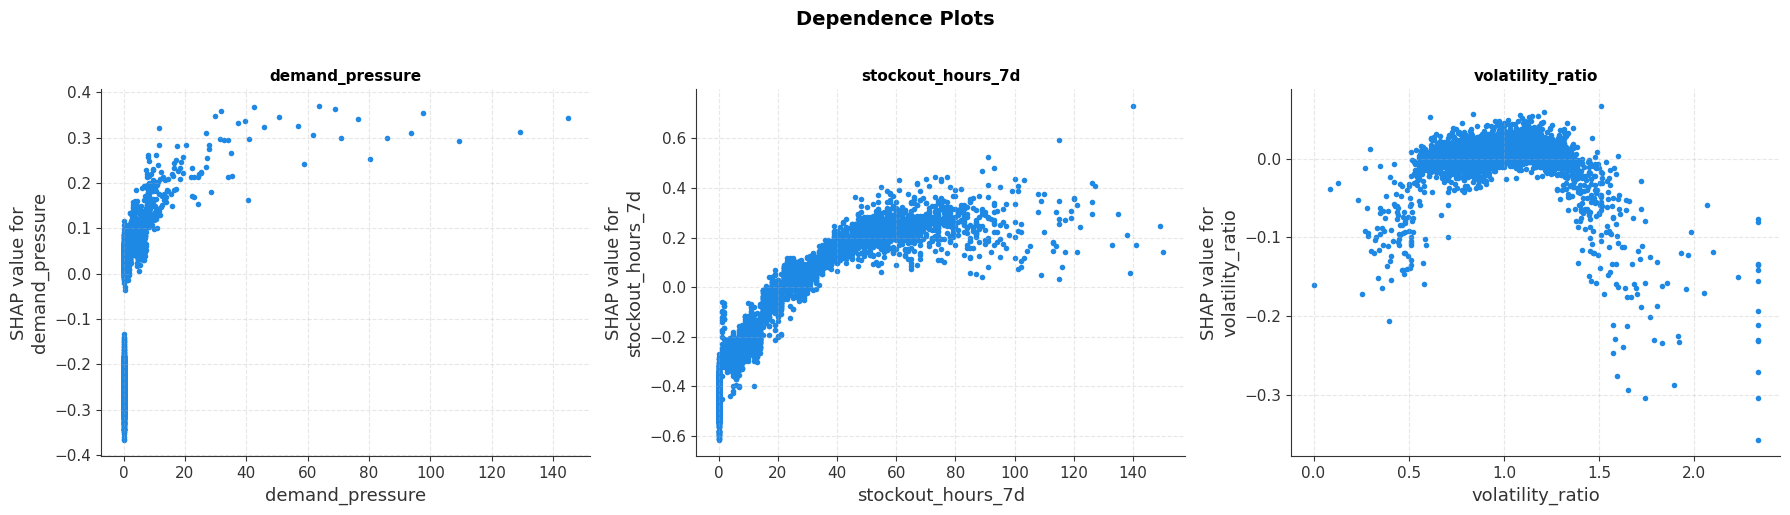

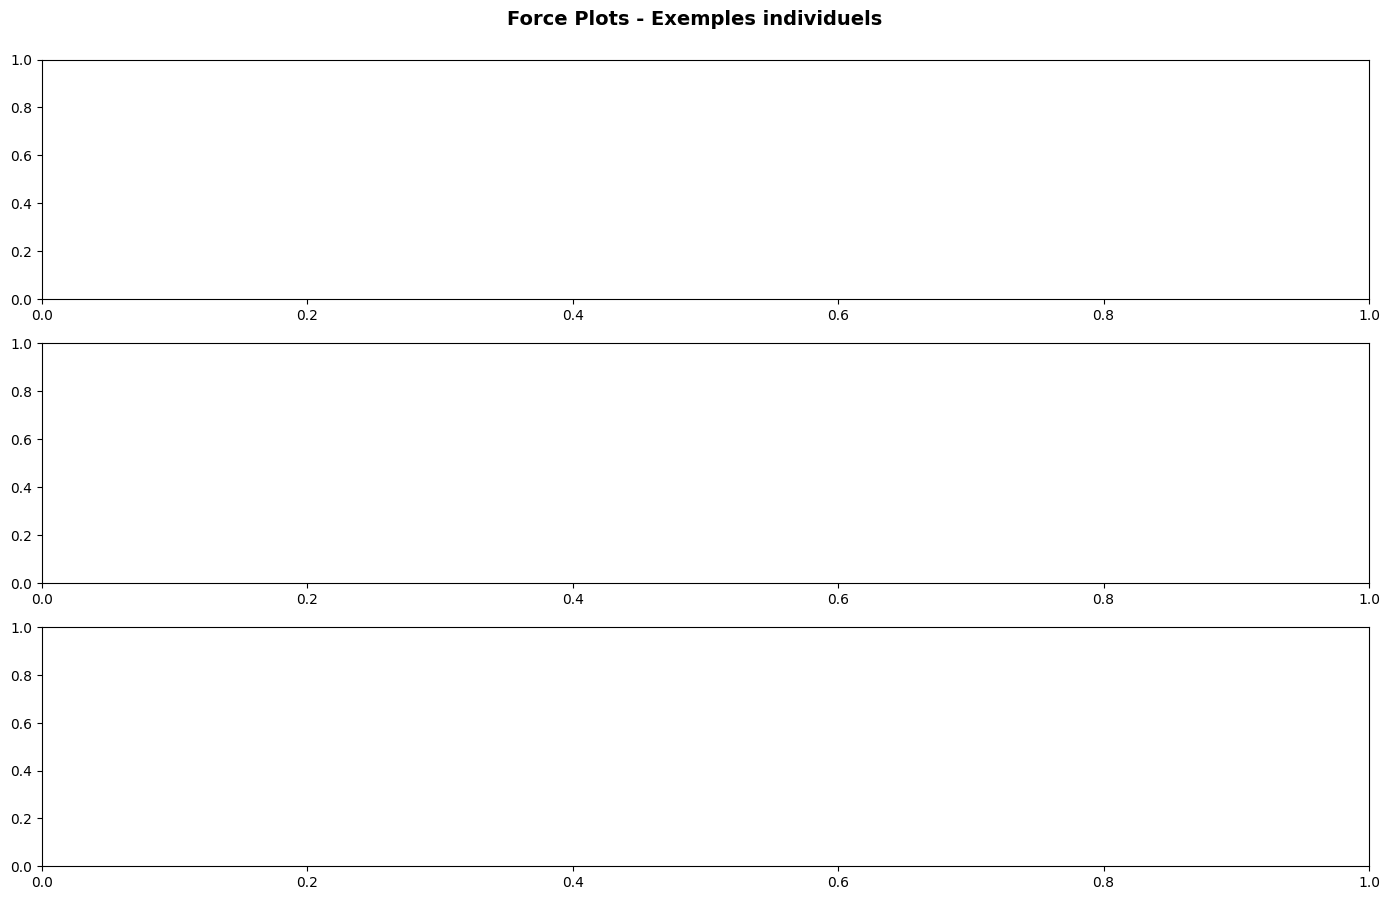

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration graphique
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Echantillon pour SHAP
SHAP_SAMPLE = 5000

X_shap = X_va.sample(
    n=min(SHAP_SAMPLE, len(X_va)),
    random_state=42
)

# Calcul SHAP
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_shap)

# Gestion classification binaire
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# GRAPHE 1: Bar plot
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Importance Globale des Features", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# GRAPHE 2: Beeswarm
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_shap,
    max_display=15,
    show=False
)
plt.title("Distribution des impacts SHAP", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# GRAPHE 3: Dependence plots (3 en ligne)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feat in enumerate(["demand_pressure", "stockout_hours_7d", "volatility_ratio"]):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feat,
        shap_values,
        X_shap,
        interaction_index=None,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f"{feat}", fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, linestyle='--')

plt.suptitle("Dependence Plots", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(14, 9))

plt.suptitle("Force Plots - Exemples individuels", fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

**Grâce à SHAP :**

Les ruptures sont précédées par :

*   pression cumulée de la demande
*   micro-ruptures
*   instabilité croissante
*   chocs exogènes (promo, météo)
*   Le modèle n’est pas une boîte noire
*   Les alertes sont explicables et actionnables